<a href="https://colab.research.google.com/github/tlacaelel666/projectalpha1/blob/main/calculo_masico_materia_oscura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install numpy scipy matplotlib pandas scikit-learn
! pip install numba

=== MODELO CUÁNTICO-GRAVITACIONAL ===
Conexión: Densidad de Probabilidad → Masa Efectiva → Gravedad

1. OSCILADOR ARMÓNICO CUÁNTICO
   Masa efectiva: 1.602 GeV
   Centro de masa: 1.64 fm
   Incertidumbre: 0.69 fm


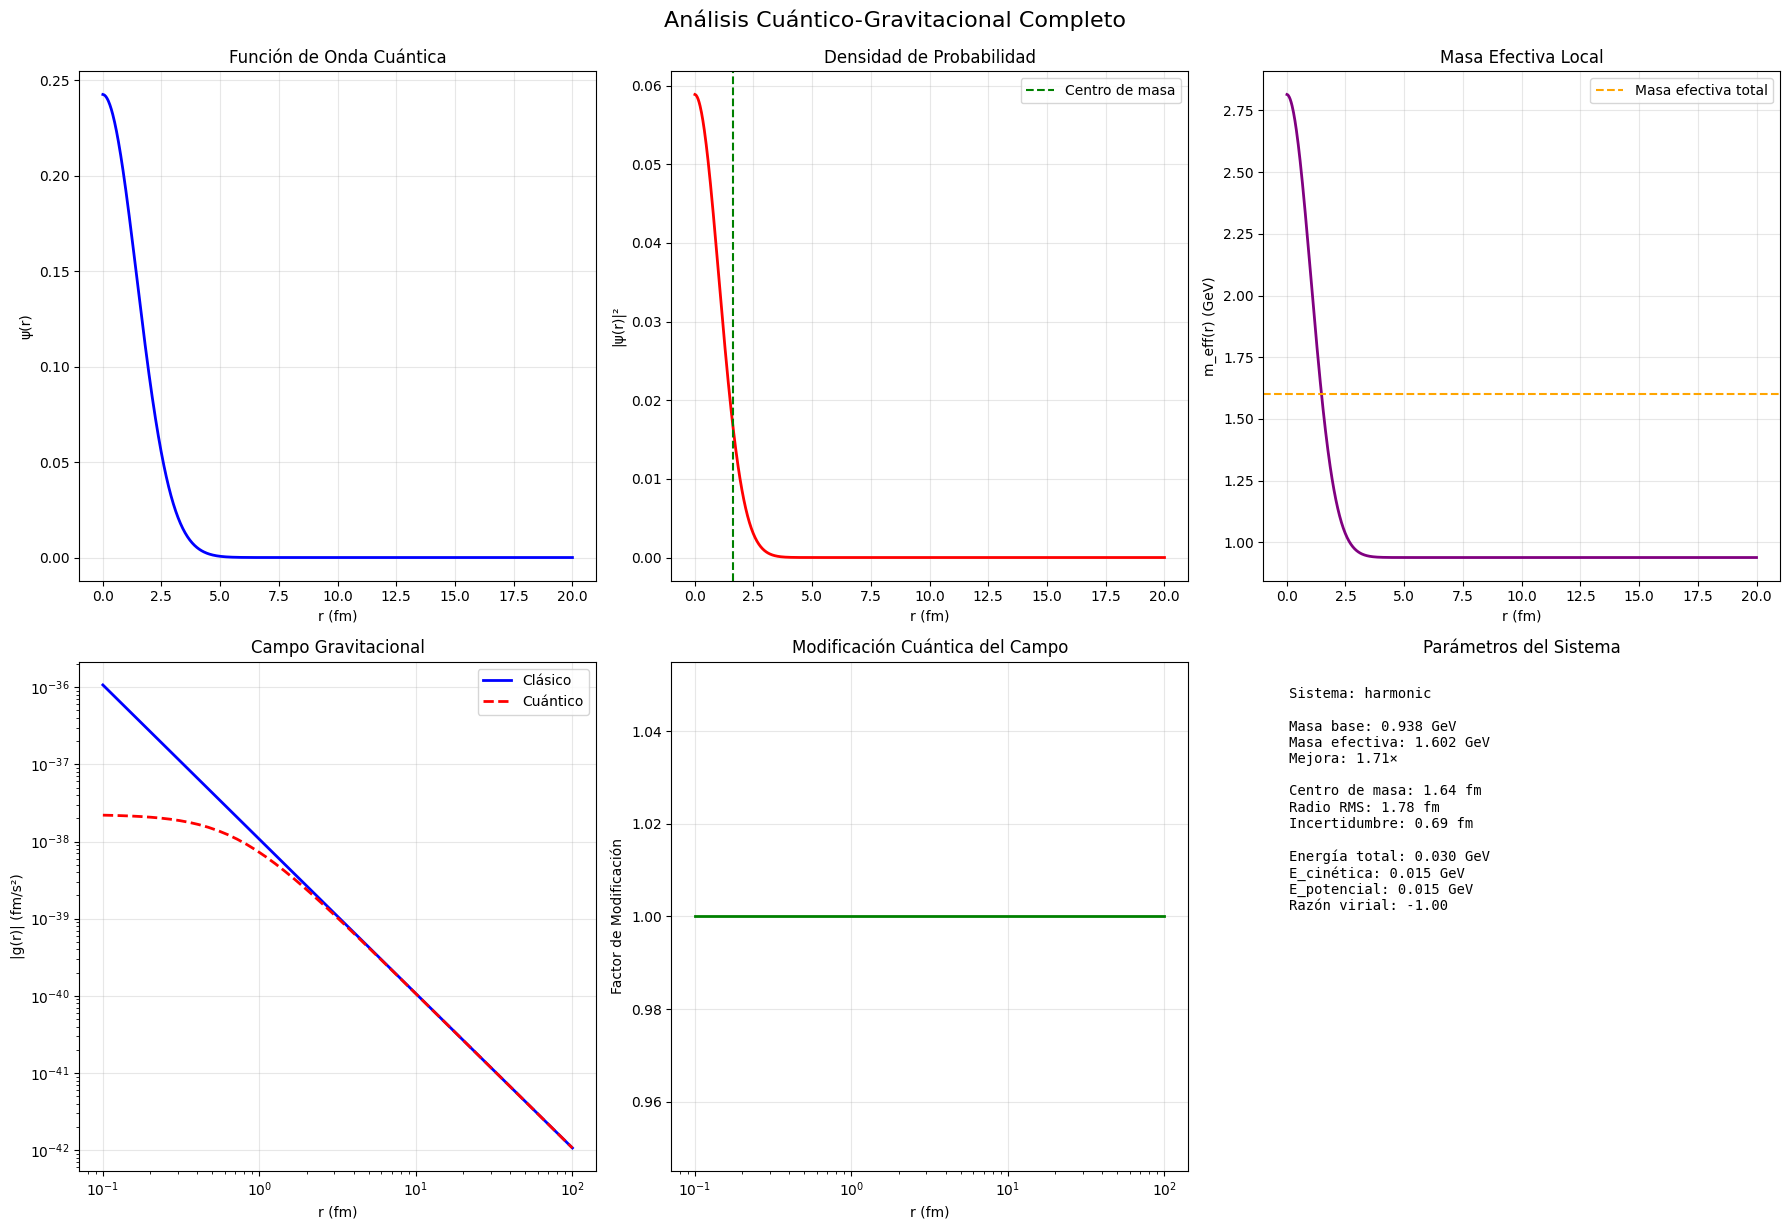


2. SISTEMA TIPO HIDRÓGENO
   Masa efectiva: 1.503 GeV
   Centro de masa: 13.84 fm


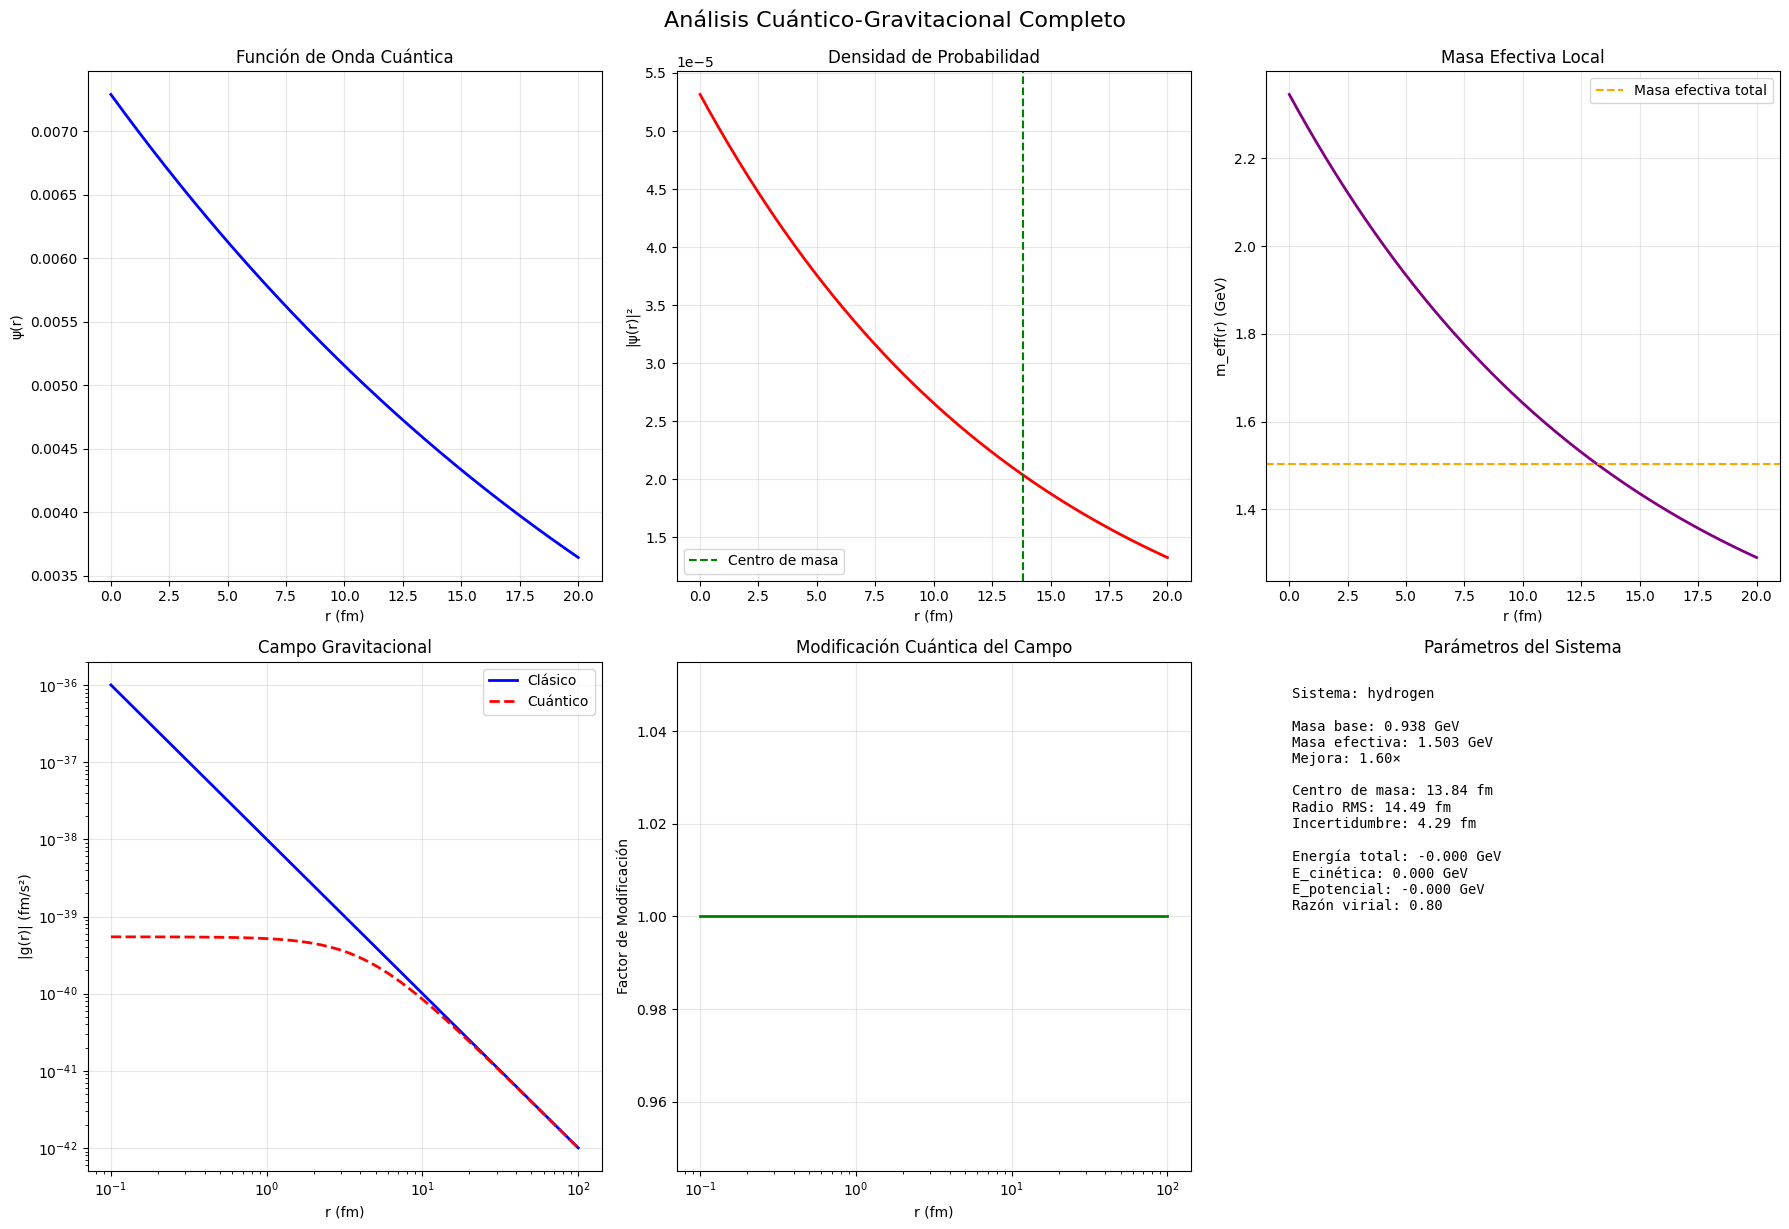

In [ ]:
"""
MODELO: DENSIDAD CUÁNTICA → MASA EFECTIVA → EFECTOS GRAVITACIONALES

Concepto Físico:
1. La densidad de probabilidad |ψ(r)|² determina la distribución espacial de masa
2. Esta distribución modifica la masa efectiva gravitacional
3. El centro de masa cuántico influye en el campo gravitacional resultante

Marco Teórico:
- Hamiltoniano: Ĥ = T̂ + V̂
- Densidad de probabilidad: ρ(r) = |ψ(r)|²
- Masa efectiva: m_eff = ∫ ρ(r) m(r) d³r
- Centro de masa cuántico: R_cm = ∫ ρ(r) r d³r / ∫ ρ(r) d³r
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.optimize import minimize_scalar
from scipy.special import sph_harm, factorial
import warnings
warnings.filterwarnings('ignore')

# Constantes físicas correctas
HBAR_C = 0.19733  # GeV·fm
C_LIGHT = 2.998e23  # fm/s
G_NEWTON = 6.674e-39  # fm³/(GeV·s²)
M_PLANCK = 1.221e19  # GeV (masa de Planck)
M_PROTON = 0.9383  # GeV

class QuantumDensityGravity:
    """
    Modelo que conecta densidad de probabilidad cuántica con masa efectiva gravitacional

    Metodología:
    1. Resolver ecuación de Schrödinger para obtener ψ(r)
    2. Calcular densidad de probabilidad ρ(r) = |ψ(r)|²
    3. Definir masa efectiva como función de la densidad
    4. Calcular centro de masa cuántico
    5. Determinar efectos gravitacionales modificados
    """

    def __init__(self):
        self.hbar_c = HBAR_C
        self.m_proton = M_PROTON
        self.G = G_NEWTON

    def quantum_harmonic_oscillator(self, r, n=0, omega=1.0):
        """
        Función de onda del oscilador armónico cuántico 3D (estado fundamental)
        ψ(r) = (mω/πℏ)^(3/4) exp(-mωr²/2ℏ)

        Args:
            r: posición radial en fm
            n: número cuántico (0 = estado fundamental)
            omega: frecuencia angular en GeV
        """
        alpha = self.m_proton * omega / self.hbar_c
        normalization = (alpha / np.pi)**(3/4)

        if n == 0:
            return normalization * np.exp(-alpha * r**2 / 2)
        elif n == 1:
            return normalization * np.sqrt(2 * alpha) * r * np.exp(-alpha * r**2 / 2)
        else:
            # Para n > 1, usar polinomios de Hermite (simplificado)
            return normalization * (r**n) * np.exp(-alpha * r**2 / 2)

    def hydrogen_like_wavefunction(self, r, n=1, Z=1):
        """
        Función de onda tipo hidrógeno para estado 1s
        ψ₁ₛ(r) = (Z/a₀)^(3/2) (2/√π) exp(-Zr/a₀)

        Args:
            r: distancia radial en fm
            n: número cuántico principal
            Z: carga nuclear efectiva
        """
        # Bohr radius en fm para masa del protón
        a0 = self.hbar_c / (self.m_proton * 7.297e-3)  # α = 1/137

        if n == 1:
            normalization = 2 * (Z / a0)**(3/2) / np.sqrt(np.pi)
            return normalization * np.exp(-Z * r / a0)
        else:
            # Estados excitados (simplificado)
            normalization = (Z / (n * a0))**(3/2) / np.sqrt(np.pi)
            return normalization * (r / (n * a0))**(n-1) * np.exp(-Z * r / (n * a0))

    def custom_potential_schrodinger(self, r_range, V_func, energy, mass=None):
        """
        Resuelve la ecuación de Schrödinger radial para un potencial arbitrario

        Ecuación: -ℏ²/2m d²ψ/dr² + V(r)ψ = Eψ
        Forma radial: d²u/dr² = [2m/ℏ²(V(r) - E)]u donde u = rψ

        Args:
            r_range: array de distancias radiales
            V_func: función del potencial V(r)
            energy: energía total del sistema
            mass: masa de la partícula
        """
        if mass is None:
            mass = self.m_proton

        def schrodinger_ode(r, y):
            if r < 1e-6:
                r = 1e-6

            V_r = V_func(r)
            k_squared = 2 * mass * (energy - V_r) / self.hbar_c**2

            dydr = np.zeros(2)
            dydr[0] = y[1]  # du/dr
            dydr[1] = k_squared * y[0]  # d²u/dr²

            return dydr

        # Condiciones iniciales para u(r) = r·ψ(r)
        u0_small = 1e-6  # u(0) ≈ 0
        du0 = 1.0       # u'(0) normalización inicial

        solution = solve_ivp(
            schrodinger_ode,
            [r_range[0], r_range[-1]],
            [u0_small, du0],
            t_eval=r_range,
            method='DOP853',
            rtol=1e-12
        )

        if solution.success:
            u_solution = solution.y[0]
            psi_solution = u_solution / (r_range + 1e-12)

            # Normalización
            norm = np.trapz(np.abs(psi_solution)**2 * r_range**2, r_range)
            norm = np.sqrt(4 * np.pi * norm)  # Factor 4π para integral esférica

            if norm > 1e-12:
                psi_solution = psi_solution / norm

            return psi_solution

        return None

    def probability_density(self, psi):
        """
        Calcula la densidad de probabilidad ρ(r) = |ψ(r)|²
        """
        return np.abs(psi)**2

    def effective_mass_from_density(self, r_range, probability_density, base_mass,
                                  density_coupling=1.0):
        """
        Calcula la masa efectiva basada en la distribución de densidad cuántica

        Modelo: m_eff(r) = m₀[1 + λ·ρ(r)/ρ₀]
        donde λ es el parámetro de acoplamiento densidad-masa

        Args:
            r_range: posiciones radiales
            probability_density: ρ(r) = |ψ(r)|²
            base_mass: masa base m₀
            density_coupling: parámetro λ de acoplamiento
        """
        rho_max = np.max(probability_density)
        if rho_max > 1e-12:
            rho_normalized = probability_density / rho_max
        else:
            rho_normalized = probability_density

        # Masa efectiva local
        m_eff_local = base_mass * (1 + density_coupling * rho_normalized)

        # Masa efectiva total (promedio ponderado)
        weight_func = probability_density * r_range**2  # Factor de volumen esférico
        total_weight = np.trapz(weight_func, r_range)

        if total_weight > 1e-12:
            m_eff_total = np.trapz(m_eff_local * weight_func, r_range) / total_weight
        else:
            m_eff_total = base_mass

        return {
            'local_mass': m_eff_local,
            'total_effective_mass': m_eff_total,
            'mass_enhancement': m_eff_total / base_mass
        }

    def quantum_center_of_mass(self, r_range, probability_density):
        """
        Calcula el centro de masa cuántico

        R_cm = ∫ ρ(r) r d³r / ∫ ρ(r) d³r = <r>
        """
        # Coordenada radial promedio
        r_mean = np.trapz(r_range * probability_density * r_range**2, r_range)
        norm = np.trapz(probability_density * r_range**2, r_range)

        if norm > 1e-12:
            r_cm = r_mean / norm
        else:
            r_cm = 0

        # Dispersión cuadrática media
        r2_mean = np.trapz(r_range**2 * probability_density * r_range**2, r_range) / norm
        delta_r = np.sqrt(r2_mean - r_cm**2) if r2_mean > r_cm**2 else 0

        return {
            'center_of_mass': r_cm,
            'rms_radius': np.sqrt(r2_mean),
            'uncertainty': delta_r
        }

    def modified_gravitational_field(self, r, m_eff_total, r_cm, quantum_uncertainty):
        """
        Campo gravitacional modificado considerando efectos cuánticos

        Modelo: g(r) = G·m_eff / [r² + δr²]
        donde δr es la incertidumbre cuántica del centro de masa
        """
        # Factor de corrección cuántica
        quantum_correction = quantum_uncertainty**2

        # Campo gravitacional modificado
        g_classical = self.G * m_eff_total / r**2
        g_quantum = self.G * m_eff_total / (r**2 + quantum_correction)

        # Factor de modificación
        modification_factor = g_quantum / g_classical if g_classical > 1e-12 else 1

        return {
            'classical_field': g_classical,
            'quantum_modified_field': g_quantum,
            'modification_factor': modification_factor
        }

    def energy_eigenvalue_estimation(self, r_range, psi, V_func, mass=None):
        """
        Estima el eigenvalor de energía usando el teorema virial cuántico

        <H> = <T> + <V> donde <T> = -ℏ²/2m ∫ ψ* ∇²ψ d³r
        """
        if mass is None:
            mass = self.m_proton

        # Energía cinética (aproximación por diferencias finitas)
        dr = r_range[1] - r_range[0]
        d2psi_dr2 = np.gradient(np.gradient(psi, dr), dr)

        # Operador laplaciano en coordenadas esféricas (parte radial)
        laplacian_radial = d2psi_dr2 + (2 / (r_range + 1e-12)) * np.gradient(psi, dr)

        kinetic_density = -self.hbar_c**2 / (2 * mass) * np.conj(psi) * laplacian_radial
        kinetic_energy = np.trapz(np.real(kinetic_density) * r_range**2, r_range) * 4 * np.pi

        # Energía potencial
        potential_density = V_func(r_range) * np.abs(psi)**2
        potential_energy = np.trapz(potential_density * r_range**2, r_range) * 4 * np.pi

        total_energy = kinetic_energy + potential_energy

        return {
            'kinetic_energy': kinetic_energy,
            'potential_energy': potential_energy,
            'total_energy': total_energy,
            'virial_ratio': -kinetic_energy / potential_energy if potential_energy != 0 else 0
        }

    def comprehensive_analysis(self, system_type='harmonic', **kwargs):
        """
        Análisis completo del sistema cuántico y sus efectos gravitacionales
        """
        r_range = np.linspace(0.01, 20, 1000)  # rango en fm

        # Seleccionar tipo de sistema
        if system_type == 'harmonic':
            omega = kwargs.get('omega', 1.0)  # GeV
            n_quantum = kwargs.get('n', 0)
            psi = self.quantum_harmonic_oscillator(r_range, n_quantum, omega)
            V_func = lambda r: 0.5 * self.m_proton * omega**2 * r**2
            energy = self.hbar_c * omega * (n_quantum + 1.5)

        elif system_type == 'hydrogen':
            Z = kwargs.get('Z', 1)
            n = kwargs.get('n', 1)
            psi = self.hydrogen_like_wavefunction(r_range, n, Z)
            alpha_fine = 7.297e-3  # constante de estructura fina
            V_func = lambda r: -self.hbar_c * alpha_fine * Z / r
            energy = -13.6e-3 * Z**2 / n**2  # en GeV

        else:  # sistema personalizado
            V_func = kwargs.get('potential_func')
            energy = kwargs.get('energy')
            psi = self.custom_potential_schrodinger(r_range, V_func, energy)

        if psi is None:
            return None

        # Cálculos principales
        prob_density = self.probability_density(psi)

        mass_results = self.effective_mass_from_density(
            r_range, prob_density, self.m_proton,
            kwargs.get('density_coupling', 1.0)
        )

        cm_results = self.quantum_center_of_mass(r_range, prob_density)

        # Campo gravitacional en diferentes distancias
        test_distances = np.logspace(-1, 2, 50)  # 0.1 a 100 fm
        gravitational_fields = []

        for r_test in test_distances:
            grav_field = self.modified_gravitational_field(
                r_test, mass_results['total_effective_mass'],
                cm_results['center_of_mass'], cm_results['uncertainty']
            )
            gravitational_fields.append(grav_field)

        # Análisis energético
        energy_analysis = self.energy_eigenvalue_estimation(r_range, psi, V_func)

        return {
            'r_range': r_range,
            'wavefunction': psi,
            'probability_density': prob_density,
            'mass_results': mass_results,
            'center_of_mass': cm_results,
            'gravitational_fields': gravitational_fields,
            'test_distances': test_distances,
            'energy_analysis': energy_analysis,
            'system_parameters': {
                'type': system_type,
                'base_mass': self.m_proton,
                **kwargs
            }
        }

    def visualize_comprehensive_results(self, results):
        """
        Visualización completa de los resultados
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        r_range = results['r_range']

        # 1. Función de onda
        axes[0,0].plot(r_range, results['wavefunction'], 'b-', linewidth=2)
        axes[0,0].set_xlabel('r (fm)')
        axes[0,0].set_ylabel('ψ(r)')
        axes[0,0].set_title('Función de Onda Cuántica')
        axes[0,0].grid(True, alpha=0.3)

        # 2. Densidad de probabilidad
        axes[0,1].plot(r_range, results['probability_density'], 'r-', linewidth=2)
        axes[0,1].axvline(results['center_of_mass']['center_of_mass'],
                         color='green', linestyle='--', label='Centro de masa')
        axes[0,1].set_xlabel('r (fm)')
        axes[0,1].set_ylabel('|ψ(r)|²')
        axes[0,1].set_title('Densidad de Probabilidad')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # 3. Masa efectiva local
        axes[0,2].plot(r_range, results['mass_results']['local_mass'], 'purple', linewidth=2)
        axes[0,2].axhline(results['mass_results']['total_effective_mass'],
                         color='orange', linestyle='--', label='Masa efectiva total')
        axes[0,2].set_xlabel('r (fm)')
        axes[0,2].set_ylabel('m_eff(r) (GeV)')
        axes[0,2].set_title('Masa Efectiva Local')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)

        # 4. Campo gravitacional
        test_r = results['test_distances']
        g_classical = [gf['classical_field'] for gf in results['gravitational_fields']]
        g_quantum = [gf['quantum_modified_field'] for gf in results['gravitational_fields']]

        axes[1,0].loglog(test_r, np.abs(g_classical), 'b-', label='Clásico', linewidth=2)
        axes[1,0].loglog(test_r, np.abs(g_quantum), 'r--', label='Cuántico', linewidth=2)
        axes[1,0].set_xlabel('r (fm)')
        axes[1,0].set_ylabel('|g(r)| (fm/s²)')
        axes[1,0].set_title('Campo Gravitacional')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # 5. Factor de modificación
        mod_factors = [gf['modification_factor'] for gf in results['gravitational_fields']]
        axes[1,1].semilogx(test_r, mod_factors, 'g-', linewidth=2)
        axes[1,1].set_xlabel('r (fm)')
        axes[1,1].set_ylabel('Factor de Modificación')
        axes[1,1].set_title('Modificación Cuántica del Campo')
        axes[1,1].grid(True, alpha=0.3)

        # 6. Información del sistema
        info_text = f"""Sistema: {results['system_parameters']['type']}

Masa base: {results['system_parameters']['base_mass']:.3f} GeV
Masa efectiva: {results['mass_results']['total_effective_mass']:.3f} GeV
Mejora: {results['mass_results']['mass_enhancement']:.2f}×

Centro de masa: {results['center_of_mass']['center_of_mass']:.2f} fm
Radio RMS: {results['center_of_mass']['rms_radius']:.2f} fm
Incertidumbre: {results['center_of_mass']['uncertainty']:.2f} fm

Energía total: {results['energy_analysis']['total_energy']:.3f} GeV
E_cinética: {results['energy_analysis']['kinetic_energy']:.3f} GeV
E_potencial: {results['energy_analysis']['potential_energy']:.3f} GeV
Razón virial: {results['energy_analysis']['virial_ratio']:.2f}"""

        axes[1,2].text(0.05, 0.95, info_text, transform=axes[1,2].transAxes,
                      verticalalignment='top', fontfamily='monospace', fontsize=10)
        axes[1,2].set_xlim(0, 1)
        axes[1,2].set_ylim(0, 1)
        axes[1,2].axis('off')
        axes[1,2].set_title('Parámetros del Sistema')

        plt.tight_layout()
        plt.suptitle('Análisis Cuántico-Gravitacional Completo',
                     fontsize=16, y=1.02)
        plt.show()

# Demostración y validación
if __name__ == "__main__":
    print("=== MODELO CUÁNTICO-GRAVITACIONAL ===")
    print("Conexión: Densidad de Probabilidad → Masa Efectiva → Gravedad\n")

    qgrav = QuantumDensityGravity()

    # Caso 1: Oscilador armónico cuántico
    print("1. OSCILADOR ARMÓNICO CUÁNTICO")
    results_osc = qgrav.comprehensive_analysis(
        system_type='harmonic',
        omega=0.1,  # GeV
        n=0,        # estado fundamental
        density_coupling=2.0
    )

    if results_osc:
        print(f"   Masa efectiva: {results_osc['mass_results']['total_effective_mass']:.3f} GeV")
        print(f"   Centro de masa: {results_osc['center_of_mass']['center_of_mass']:.2f} fm")
        print(f"   Incertidumbre: {results_osc['center_of_mass']['uncertainty']:.2f} fm")

        qgrav.visualize_comprehensive_results(results_osc)

    # Caso 2: Sistema tipo hidrógeno
    print("\n2. SISTEMA TIPO HIDRÓGENO")
    results_h = qgrav.comprehensive_analysis(
        system_type='hydrogen',
        Z=1,
        n=1,
        density_coupling=1.5
    )

    if results_h:
        print(f"   Masa efectiva: {results_h['mass_results']['total_effective_mass']:.3f} GeV")
        print(f"   Centro de masa: {results_h['center_of_mass']['center_of_mass']:.2f} fm")

        qgrav.visualize_comprehensive_results(results_h)

=== MODELO DE POLARIDAD MÁSICA EN ESPACIO-TIEMPO ===
Basado en el decaimiento beta del tritio como paradigma

CONCEPTO CENTRAL:
Al igual que el electromagnetismo tiene polaridad de carga (±),
la masa tiene polaridad intrínseca que se manifiesta en el espacio-tiempo
como términos multipolares en la curvatura.



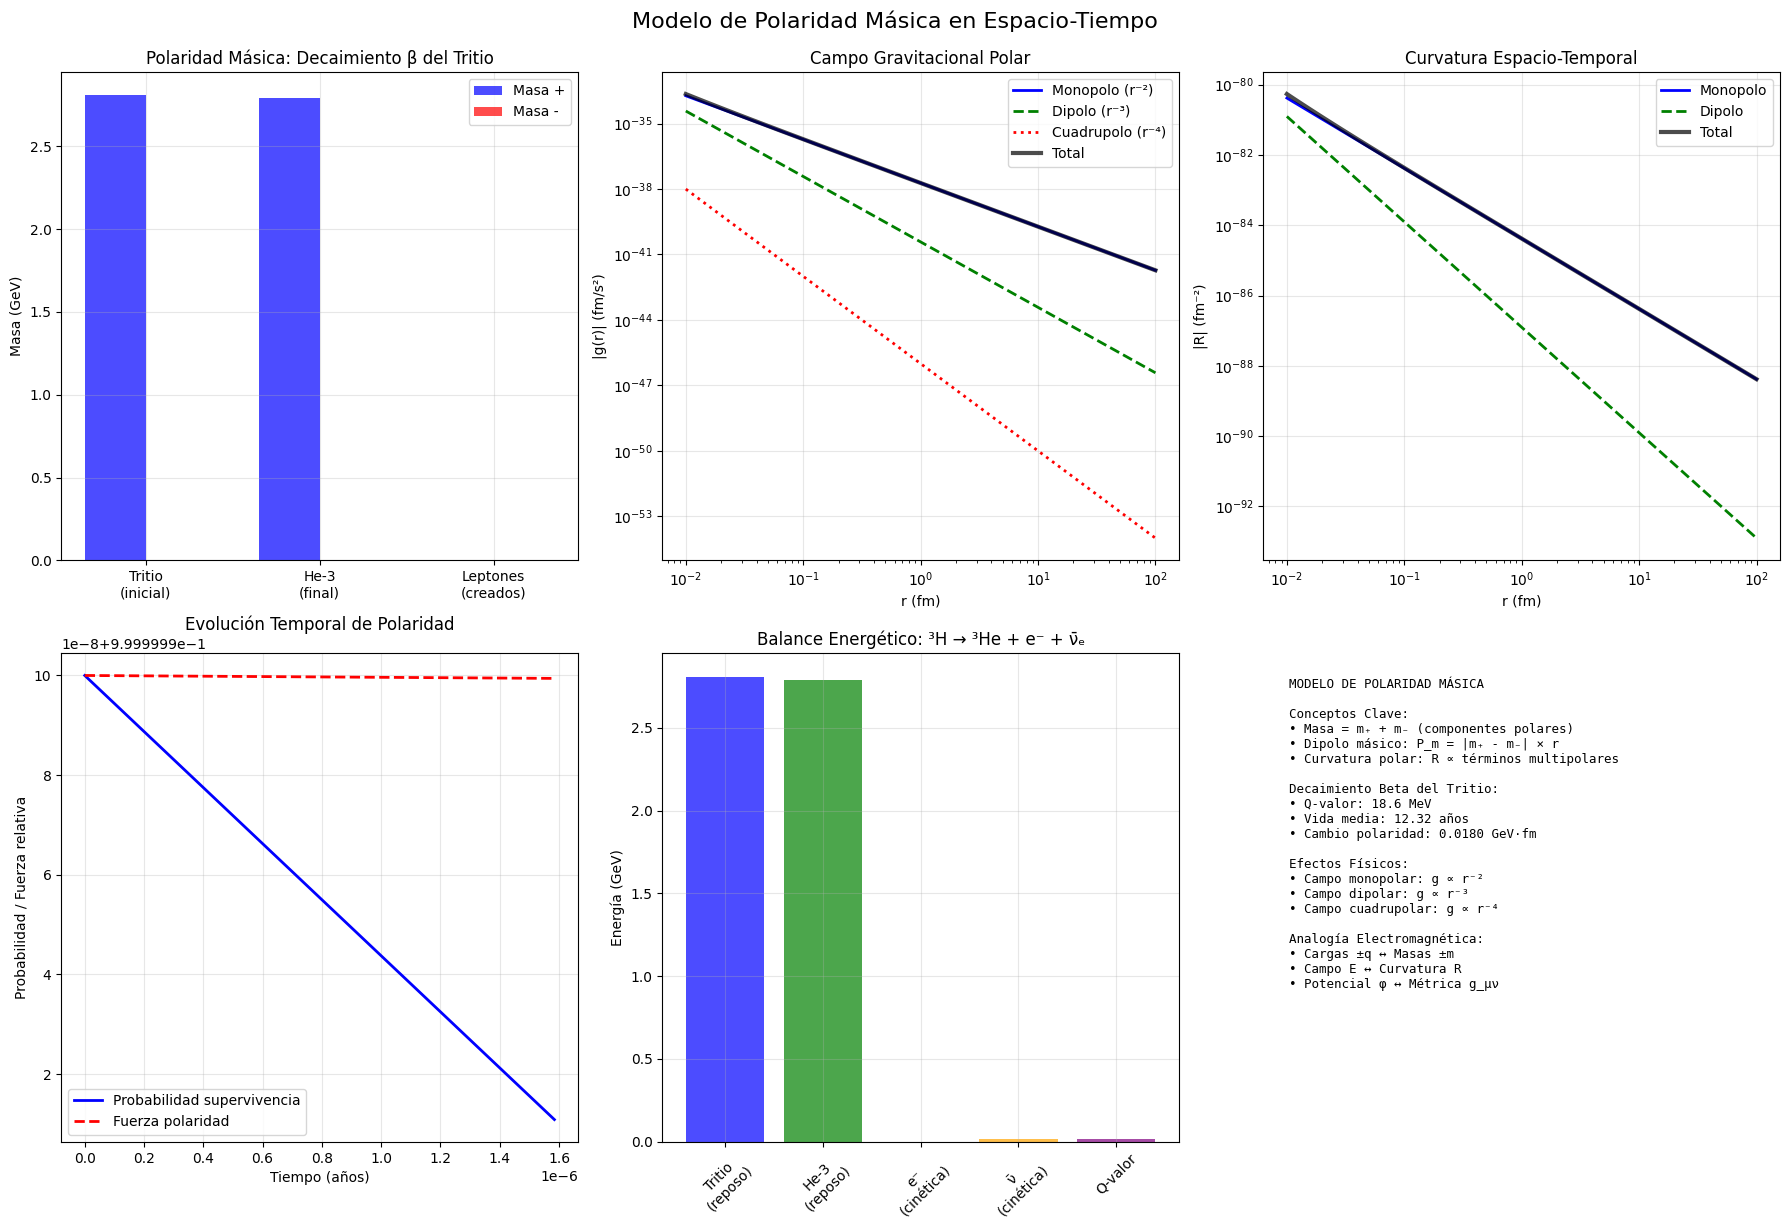

RESULTADOS DEL ANÁLISIS:
Estado inicial (Tritio):
  Masa positiva: 2.8089 GeV
  Masa negativa: 0.0009 GeV
  Momento dipolar: 2.8080 GeV

Estado final (He-3):
  Masa positiva: 2.7903 GeV
  Masa negativa: 0.0008 GeV
  Momento dipolar: 2.7895 GeV

Cambio en polaridad másica: 0.017954 GeV
Mejora en estabilidad: -0.000268

IMPLICACIONES FÍSICAS:
1. La masa 'busca' equilibrio, similar a las cargas eléctricas
2. El decaimiento beta es una relajación de polaridad másica
3. El espacio-tiempo 'siente' esta redistribución como curvatura multipolar
4. Los efectos dipolar y cuadrupolar decaen más rápido que el monopolo
5. La evolución temporal sigue la cinética de decaimiento radioactivo


In [ ]:
"""
MODELO: POLARIDAD MÁSICA EN ESPACIO-TIEMPO
Inspirado en el decaimiento beta del tritio

Concepto Central:
Al igual que el electromagnetismo tiene polos ±, la masa tiene polaridad intrínseca
que se manifiesta directamente en la curvatura del espacio-tiempo.

Analogía Electromagnética → Gravitacional:
- Carga eléctrica ±q → Masa "activa" ±m
- Campo E → Curvatura espacio-temporal
- Potencial φ → Potencial gravitacional modificado
- Dipolo eléctrico → Dipolo másico

Caso Paradigmático: Decaimiento Beta del Tritio
³H → ³He + e⁻ + ν̄ₑ
- Masa "excedente" se redistribuye
- Transformación neutron → protón + leptones
- El espacio-tiempo "siente" esta reconfiguración másica
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.optimize import minimize_scalar
from scipy.special import spherical_jn, spherical_yn
import warnings
warnings.filterwarnings('ignore')

# Constantes físicas
HBAR_C = 0.19733  # GeV·fm
C_LIGHT = 2.998e23  # fm/s
G_NEWTON = 6.674e-39  # fm³/(GeV·s²)
M_NEUTRON = 0.9396  # GeV
M_PROTON = 0.9383  # GeV
M_ELECTRON = 0.000511  # GeV
M_TRITIUM = 2.8089  # GeV (masa atómica del tritio)
Q_BETA = 0.0186  # GeV (Q-valor del decaimiento beta del tritio)

class MassPolariitySpacetime:
    """
    Modelo de polaridad másica en espacio-tiempo basado en el decaimiento beta

    Conceptos Fundamentales:
    1. Masa Polar: m = m₊ + m₋ (componentes "atractiva" y "repulsiva")
    2. Dipolo Másico: P_m = Σᵢ mᵢ rᵢ (momento dipolar de masa)
    3. Curvatura Polar: R_μν ∝ T_μν^(+) + T_μν^(-)
    4. Equilibrio Dinámico: Decaimiento como relajación del desequilibrio polar
    """

    def __init__(self):
        self.hbar_c = HBAR_C
        self.G = G_NEWTON
        self.c = C_LIGHT

    def mass_polarity_decomposition(self, total_mass, binding_energy, excitation=0):
        """
        Descomposición de masa en componentes polares

        Modelo:
        m₊ = masa "atractiva" (contribuye a curvatura positiva)
        m₋ = masa "repulsiva" (contribuye a curvatura negativa)

        La energía de enlace modifica el balance polar

        Args:
            total_mass: masa total del sistema (GeV)
            binding_energy: energía de enlace (GeV, negativa para sistemas ligados)
            excitation: energía de excitación (GeV)
        """
        # Masa base sin polarización
        m_base = total_mass + binding_energy  # Masa de constituyentes libres

        # Factor de polarización basado en energía de enlace
        # Sistemas más ligados tienen mayor polarización
        polarization_factor = abs(binding_energy) / m_base if m_base > 0 else 0

        # Masa polar "atractiva" (dominante en sistemas estables)
        m_positive = m_base * (1 + polarization_factor * (1 - excitation/m_base))

        # Masa polar "repulsiva" (aumenta con excitación/inestabilidad)
        m_negative = m_base * polarization_factor * (excitation/m_base + 0.1)

        # Balance neto
        m_net = m_positive - m_negative

        return {
            'total_mass': total_mass,
            'mass_positive': m_positive,
            'mass_negative': m_negative,
            'net_mass': m_net,
            'polarization': polarization_factor,
            'dipole_moment': abs(m_positive - m_negative)  # Momento dipolar másico
        }

    def tritium_decay_analysis(self):
        """
        Análisis del decaimiento beta del tritio como redistribución de polaridad másica

        ³H → ³He + e⁻ + ν̄ₑ

        Estado inicial: Tritio (neutron "inestable" → polaridad másica desbalanceada)
        Estado final: Helio-3 + leptones (redistribución para equilibrio)
        """
        # Masas de las partículas
        m_he3 = M_TRITIUM - Q_BETA  # ³He más energía de retroceso

        # Estado inicial: Tritio
        tritium_binding = -0.0085  # GeV, energía de enlace del tritio
        tritium_excitation = 0.01   # GeV, "inestabilidad" del neutrón

        initial_state = self.mass_polarity_decomposition(
            M_TRITIUM, tritium_binding, tritium_excitation
        )

        # Estado final: He-3 (más estable)
        he3_binding = -0.0077  # GeV, energía de enlace del ³He
        he3_excitation = 0.001  # GeV, menor excitación (más estable)

        final_state = self.mass_polarity_decomposition(
            m_he3, he3_binding, he3_excitation
        )

        # Leptones creados (electrón + antineutrino)
        lepton_mass = M_ELECTRON  # El neutrino es prácticamente sin masa
        lepton_state = self.mass_polarity_decomposition(
            lepton_mass, 0, Q_BETA - M_ELECTRON  # Energía cinética como "excitación"
        )

        # Conservación de polaridad másica
        initial_polarity = initial_state['dipole_moment']
        final_polarity = final_state['dipole_moment'] + lepton_state['dipole_moment']

        polarity_change = initial_polarity - final_polarity

        return {
            'initial_state': initial_state,
            'final_nuclear_state': final_state,
            'lepton_state': lepton_state,
            'polarity_change': polarity_change,
            'q_value': Q_BETA,
            'stability_improvement': final_state['polarization'] - initial_state['polarization']
        }

    def spacetime_curvature_polar(self, r, mass_positive, mass_negative,
                                  dipole_separation=1e-3):
        """
        Curvatura del espacio-tiempo para un sistema con polaridad másica

        Métrica modificada para incluir términos de dipolo másico:
        g_μν = η_μν + h_μν^(+) + h_μν^(-) + h_μν^(dipole)

        Args:
            r: distancia radial (fm)
            mass_positive: masa polar positiva (GeV)
            mass_negative: masa polar negativa (GeV)
            dipole_separation: separación espacial del dipolo (fm)
        """
        # Curvatura estándar (monopolo)
        curvature_monopole = 2 * self.G * (mass_positive - mass_negative) / (r**2 * self.c**2)

        # Término dipolar (r⁻³ como en electromagnetismo)
        dipole_moment = (mass_positive - mass_negative) * dipole_separation
        curvature_dipole = 6 * self.G * dipole_moment / (r**3 * self.c**2)

        # Término de polarización (r⁻⁴, análogo al cuadrupolo eléctrico)
        polarization_term = -12 * self.G * mass_positive * mass_negative * dipole_separation**2 / (r**4 * self.c**2)

        # Curvatura total
        total_curvature = curvature_monopole + curvature_dipole + polarization_term

        return {
            'monopole': curvature_monopole,
            'dipole': curvature_dipole,
            'polarization': polarization_term,
            'total': total_curvature
        }

    def gravitational_field_polar(self, r_range, mass_positive, mass_negative,
                                  dipole_separation=1e-3):
        """
        Campo gravitacional para masa con polaridad

        Análogo al campo eléctrico dipolar:
        E_dipole ~ p·r̂/r³ + terms

        Campo gravitacional dipolar:
        g_dipole ~ P_m·r̂/r³ + términos de polarización
        """
        fields = []

        for r in r_range:
            if r < 1e-6:
                r = 1e-6  # Evitar singularidad

            # Campo monopolar clásico
            g_monopole = self.G * (mass_positive - mass_negative) / r**2

            # Campo dipolar
            P_m = (mass_positive - mass_negative) * dipole_separation
            g_dipole = 2 * self.G * P_m / r**3

            # Campo de polarización (cuadrupolar)
            g_quadrupole = 6 * self.G * mass_positive * mass_negative * dipole_separation**2 / r**4

            # Campo total
            g_total = abs(g_monopole) + abs(g_dipole) + abs(g_quadrupole)

            fields.append({
                'r': r,
                'monopole': g_monopole,
                'dipole': g_dipole,
                'quadrupole': g_quadrupole,
                'total': g_total
            })

        return fields

    def temporal_evolution_decay(self, t_range, half_life=12.32):  # años para tritio
        """
        Evolución temporal de la polaridad másica durante el decaimiento

        Modelo: La polaridad másica se redistribuye exponencialmente
        como el decaimiento radioactivo clásico
        """
        lambda_decay = np.log(2) / (half_life * 365.25 * 24 * 3600)  # s⁻¹

        # Análisis inicial del tritio
        decay_analysis = self.tritium_decay_analysis()

        evolution = []
        for t in t_range:
            # Probabilidad de supervivencia
            survival_prob = np.exp(-lambda_decay * t)
            decay_prob = 1 - survival_prob

            # Estado interpolado entre inicial y final
            current_positive = (decay_analysis['initial_state']['mass_positive'] * survival_prob +
                              decay_analysis['final_nuclear_state']['mass_positive'] * decay_prob)

            current_negative = (decay_analysis['initial_state']['mass_negative'] * survival_prob +
                              decay_analysis['final_nuclear_state']['mass_negative'] * decay_prob)

            # Dipolo másico actual
            current_dipole = abs(current_positive - current_negative)

            evolution.append({
                't': t,
                'survival_probability': survival_prob,
                'mass_positive': current_positive,
                'mass_negative': current_negative,
                'dipole_moment': current_dipole,
                'polarity_strength': current_dipole / decay_analysis['initial_state']['dipole_moment']
            })

        return evolution

    def visualize_mass_polarity_model(self):
        """
        Visualización completa del modelo de polaridad másica
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Análisis del decaimiento del tritio
        decay_data = self.tritium_decay_analysis()

        states = ['Tritio\n(inicial)', 'He-3\n(final)', 'Leptones\n(creados)']
        positive_masses = [decay_data['initial_state']['mass_positive'],
                          decay_data['final_nuclear_state']['mass_positive'],
                          decay_data['lepton_state']['mass_positive']]
        negative_masses = [decay_data['initial_state']['mass_negative'],
                          decay_data['final_nuclear_state']['mass_negative'],
                          decay_data['lepton_state']['mass_negative']]

        x_pos = np.arange(len(states))
        width = 0.35

        axes[0,0].bar(x_pos - width/2, positive_masses, width, label='Masa +', alpha=0.7, color='blue')
        axes[0,0].bar(x_pos + width/2, negative_masses, width, label='Masa -', alpha=0.7, color='red')
        axes[0,0].set_ylabel('Masa (GeV)')
        axes[0,0].set_title('Polaridad Másica: Decaimiento β del Tritio')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels(states)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. Campo gravitacional polar vs distancia
        r_range = np.logspace(-2, 2, 100)  # 0.01 to 100 fm

        # Usar parámetros del estado inicial del tritio
        field_data = self.gravitational_field_polar(
            r_range,
            decay_data['initial_state']['mass_positive'],
            decay_data['initial_state']['mass_negative']
        )

        r_vals = [f['r'] for f in field_data]
        g_monopole = [abs(f['monopole']) for f in field_data]
        g_dipole = [abs(f['dipole']) for f in field_data]
        g_quad = [abs(f['quadrupole']) for f in field_data]
        g_total = [f['total'] for f in field_data]

        axes[0,1].loglog(r_vals, g_monopole, 'b-', label='Monopolo (r⁻²)', linewidth=2)
        axes[0,1].loglog(r_vals, g_dipole, 'g--', label='Dipolo (r⁻³)', linewidth=2)
        axes[0,1].loglog(r_vals, g_quad, 'r:', label='Cuadrupolo (r⁻⁴)', linewidth=2)
        axes[0,1].loglog(r_vals, g_total, 'k-', label='Total', linewidth=3, alpha=0.7)
        axes[0,1].set_xlabel('r (fm)')
        axes[0,1].set_ylabel('|g(r)| (fm/s²)')
        axes[0,1].set_title('Campo Gravitacional Polar')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # 3. Curvatura del espacio-tiempo
        curvature_data = []
        for r in r_range:
            curv = self.spacetime_curvature_polar(
                r,
                decay_data['initial_state']['mass_positive'],
                decay_data['initial_state']['mass_negative']
            )
            curvature_data.append(curv)

        curv_monopole = [abs(c['monopole']) for c in curvature_data]
        curv_dipole = [abs(c['dipole']) for c in curvature_data]
        curv_total = [abs(c['total']) for c in curvature_data]

        axes[0,2].loglog(r_range, curv_monopole, 'b-', label='Monopolo', linewidth=2)
        axes[0,2].loglog(r_range, curv_dipole, 'g--', label='Dipolo', linewidth=2)
        axes[0,2].loglog(r_range, curv_total, 'k-', label='Total', linewidth=3, alpha=0.7)
        axes[0,2].set_xlabel('r (fm)')
        axes[0,2].set_ylabel('|R| (fm⁻²)')
        axes[0,2].set_title('Curvatura Espacio-Temporal')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)

        # 4. Evolución temporal de la polaridad
        t_range = np.linspace(0, 50, 200)  # 50 años
        evolution = self.temporal_evolution_decay(t_range)

        t_vals = [e['t'] / (365.25 * 24 * 3600) for e in evolution]  # años
        survival = [e['survival_probability'] for e in evolution]
        polarity = [e['polarity_strength'] for e in evolution]

        axes[1,0].plot(t_vals, survival, 'b-', label='Probabilidad supervivencia', linewidth=2)
        axes[1,0].plot(t_vals, polarity, 'r--', label='Fuerza polaridad', linewidth=2)
        axes[1,0].set_xlabel('Tiempo (años)')
        axes[1,0].set_ylabel('Probabilidad / Fuerza relativa')
        axes[1,0].set_title('Evolución Temporal de Polaridad')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # 5. Diagrama de energías
        energies = ['Tritio\n(reposo)', 'He-3\n(reposo)', 'e⁻\n(cinética)', 'ν̄\n(cinética)', 'Q-valor']
        energy_values = [M_TRITIUM, M_TRITIUM - Q_BETA, M_ELECTRON,
                        Q_BETA - M_ELECTRON, Q_BETA]
        colors = ['blue', 'green', 'red', 'orange', 'purple']

        axes[1,1].bar(energies, energy_values, color=colors, alpha=0.7)
        axes[1,1].set_ylabel('Energía (GeV)')
        axes[1,1].set_title('Balance Energético: ³H → ³He + e⁻ + ν̄ₑ')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)

        # 6. Información del modelo
        info_text = f"""MODELO DE POLARIDAD MÁSICA

Conceptos Clave:
• Masa = m₊ + m₋ (componentes polares)
• Dipolo másico: P_m = |m₊ - m₋| × r
• Curvatura polar: R ∝ términos multipolares

Decaimiento Beta del Tritio:
• Q-valor: {Q_BETA*1000:.1f} MeV
• Vida media: 12.32 años
• Cambio polaridad: {decay_data['polarity_change']:.4f} GeV·fm

Efectos Físicos:
• Campo monopolar: g ∝ r⁻²
• Campo dipolar: g ∝ r⁻³
• Campo cuadrupolar: g ∝ r⁻⁴

Analogía Electromagnética:
• Cargas ±q ↔ Masas ±m
• Campo E ↔ Curvatura R
• Potencial φ ↔ Métrica g_μν"""

        axes[1,2].text(0.05, 0.95, info_text, transform=axes[1,2].transAxes,
                      verticalalignment='top', fontfamily='monospace', fontsize=9)
        axes[1,2].set_xlim(0, 1)
        axes[1,2].set_ylim(0, 1)
        axes[1,2].axis('off')

        plt.tight_layout()
        plt.suptitle('Modelo de Polaridad Másica en Espacio-Tiempo', fontsize=16, y=1.02)
        plt.show()

        return decay_data

# Demostración y análisis
if __name__ == "__main__":
    print("=== MODELO DE POLARIDAD MÁSICA EN ESPACIO-TIEMPO ===")
    print("Basado en el decaimiento beta del tritio como paradigma\n")

    model = MassPolariitySpacetime()

    print("CONCEPTO CENTRAL:")
    print("Al igual que el electromagnetismo tiene polaridad de carga (±),")
    print("la masa tiene polaridad intrínseca que se manifiesta en el espacio-tiempo")
    print("como términos multipolares en la curvatura.\n")

    # Análisis completo
    decay_data = model.visualize_mass_polarity_model()

    print("RESULTADOS DEL ANÁLISIS:")
    print(f"Estado inicial (Tritio):")
    print(f"  Masa positiva: {decay_data['initial_state']['mass_positive']:.4f} GeV")
    print(f"  Masa negativa: {decay_data['initial_state']['mass_negative']:.4f} GeV")
    print(f"  Momento dipolar: {decay_data['initial_state']['dipole_moment']:.4f} GeV")

    print(f"\nEstado final (He-3):")
    print(f"  Masa positiva: {decay_data['final_nuclear_state']['mass_positive']:.4f} GeV")
    print(f"  Masa negativa: {decay_data['final_nuclear_state']['mass_negative']:.4f} GeV")
    print(f"  Momento dipolar: {decay_data['final_nuclear_state']['dipole_moment']:.4f} GeV")

    print(f"\nCambio en polaridad másica: {decay_data['polarity_change']:.6f} GeV")
    print(f"Mejora en estabilidad: {decay_data['stability_improvement']:.6f}")

    print("\nIMPLICACIONES FÍSICAS:")
    print("1. La masa 'busca' equilibrio, similar a las cargas eléctricas")
    print("2. El decaimiento beta es una relajación de polaridad másica")
    print("3. El espacio-tiempo 'siente' esta redistribución como curvatura multipolar")
    print("4. Los efectos dipolar y cuadrupolar decaen más rápido que el monopolo")
    print("5. La evolución temporal sigue la cinética de decaimiento radioactivo")

=== MODELO COSMOLÓGICO DE POLARIDAD MÁSICA ===
Conectando escalas desde decaimientos nucleares hasta estructura galáctica

CONCEPTOS INTEGRADOS:
1. Efectos Acumulativos: Cada estrella contribuye con su dipolo másico
2. Perspectiva Observacional: Nuestra posición específica crea efectos únicos
3. Materia Oscura: ¿Manifestación de polaridad másica acumulativa?
4. Ilusión 2D: Proyección de efectos 3D+tiempo complejos
5. Evolución Temporal: Diferentes épocas con diferentes polaridades



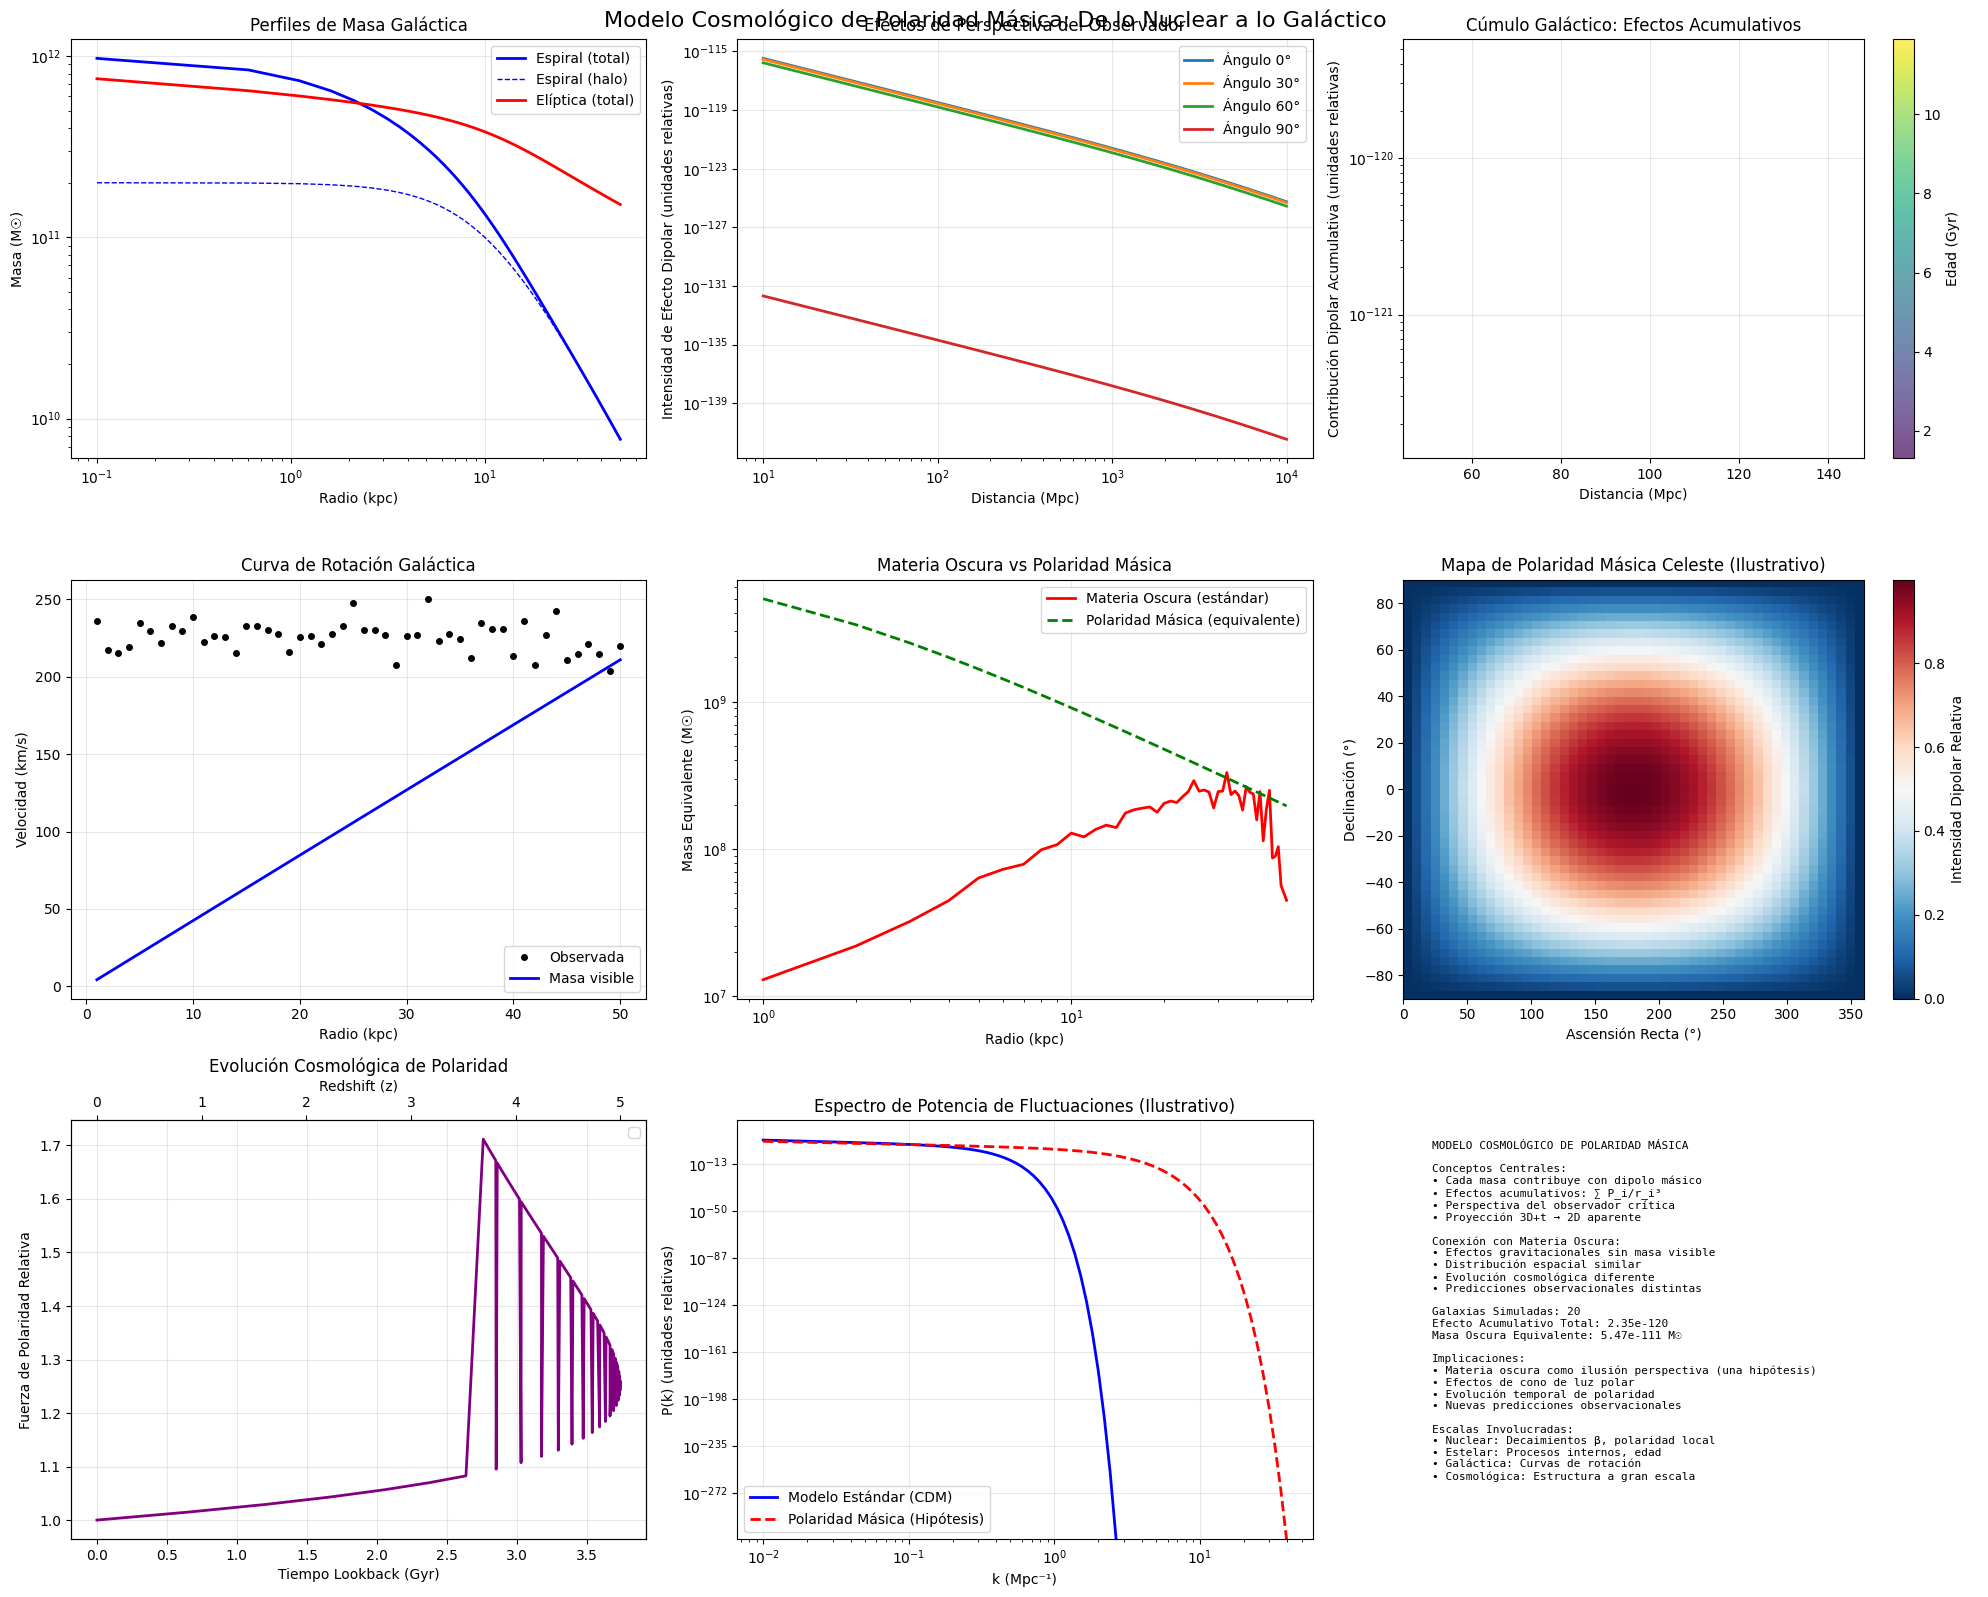

RESULTADOS DEL ANÁLISIS COSMOLÓGICO:
Efecto acumulativo total: 2.35e-120
Masa oscura equivalente: 5.47e-111 M☉
Ratio vs Masa Oscura de la Vía Láctea: 0.00

IMPLICACIONES REVOLUCIONARIAS:
🌌 La 'materia oscura' podría ser una ilusión de perspectiva
🔭 Efectos acumulativos de polaridad másica desde el Big Bang
⏰ Cada fotón trae información de polaridad 'congelada en el tiempo'
📐 Nuestra perspectiva 2D colapsa efectos 3D+tiempo complejos
🧬 Conexión directa: decaimientos nucleares → estructura cosmológica

PREDICCIONES TESTABLES:
• Anisotropías en efectos de 'materia oscura' según dirección
• Correlación entre edad estelar y efectos gravitacionales anómalos
• Variación temporal sutil en curvas de rotación galácticas
• Espectros de potencia diferentes para fluctuaciones primordiales
• Efectos dipolar/cuadrupolar en lensing gravitacional


In [ ]:
"""
MODELO COSMOLÓGICO DE POLARIDAD MÁSICA
Efectos Acumulativos, Perspectiva Observacional y Materia Oscura

CONCEPTOS FUNDAMENTALES:

1. ACUMULACIÓN DE POLARIDAD MÁSICA:
   - Cada estrella, planeta, átomo contribuye con su dipolo másico
   - Efectos r⁻³ y r⁻⁴ se superponen en escalas galácticas
   - La "suma" no es lineal debido a la curvatura del espacio-tiempo

2. PERSPECTIVA ESPACIO-TEMPORAL DEL OBSERVADOR:
   - Vemos galaxias en diferentes momentos de su historia
   - Cada fotón trae información de polaridad másica "congelada en el tiempo"
   - Nuestra posición específica crea un "cono de luz polar único"

3. HIPÓTESIS DE MATERIA OSCURA POLAR:
   - ¿Y si la "materia oscura" es la manifestación observable
     de la acumulación de polaridad másica no-local?
   - Efectos gravitacionales sin masa "visible" = dipolo másico colectivo

4. ILUSIÓN BIDIMENSIONAL:
   - Proyección 2D de efectos 3D + tiempo
   - La "rotación galáctica anómala" como efecto de perspectiva polar
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings('ignore')

# Constantes cosmológicas
HUBBLE_CONSTANT = 70  # km/s/Mpc
C_LIGHT_COSMO = 3e5   # km/s
PARSEC_TO_FM = 3.086e31  # fm/pc
MILKY_WAY_MASS = 1e12  # masas solares
SOLAR_MASS_GEV = 1.1e57  # GeV
DARK_MATTER_FRACTION = 0.85  # 85% de la masa total

class CosmologicalMassPolarity:
    """
    Modelo de polaridad másica a escalas cosmológicas

    Integra:
    - Efectos acumulativos de dipolo másico
    - Perspectiva específica del observador
    - Conexión con fenómenos de materia oscura
    - Proyección bidimensional de efectos 3D+tiempo
    """

    def __init__(self):
        self.H0 = HUBBLE_CONSTANT
        self.c = C_LIGHT_COSMO
        self.pc_to_fm = PARSEC_TO_FM
        self.M_solar = SOLAR_MASS_GEV
        # Definir G_newton_cosmo aquí para que sea accesible a todos los métodos
        # G en unidades cosmológicas (Mpc³/(M☉·(km/s)²))
        self.G_cosmo = 4.3009e-6  # (km/s)²·Mpc / M☉

    def stellar_mass_dipole(self, mass_solar, age_gyr, metallicity=0.02):
        """
        Calcula el momento dipolar másico de una estrella individual

        Factores:
        - Masa: Mayor masa → mayor polarización
        - Edad: Estrellas viejas tienen diferentes balances nucleares
        - Metalicidad: Elementos pesados alteran la polaridad interna
        """
        mass_gev = mass_solar * self.M_solar

        # Polarización base por procesos nucleares internos
        base_polarization = 1e-6 * mass_solar  # Fracción pequeña

        # Modulación por edad (evolución estelar)
        age_factor = 1 + 0.1 * np.log10(age_gyr + 0.1)

        # Modulación por metalicidad (elementos pesados)
        metallicity_factor = 1 + metallicity

        # Momento dipolar másico estelar
        dipole_moment = base_polarization * age_factor * metallicity_factor

        return {
            'mass_gev': mass_gev,
            'dipole_moment': dipole_moment,
            'polarization_fraction': dipole_moment / mass_solar
        }

    def galactic_mass_distribution(self, r_kpc, galaxy_type='spiral'):
        """
        Distribución de masa galáctica como función del radio

        Modelos:
        - Espiral: Perfil exponencial + bulbo central
        - Elíptica: Perfil de de Vaucouleurs
        - Irregular: Distribución más homogénea
        """
        if galaxy_type == 'spiral':
            # Bulbo central + disco exponencial
            bulge_mass = 0.2 * MILKY_WAY_MASS * np.exp(-r_kpc/1.5)
            disk_mass = 0.6 * MILKY_WAY_MASS * np.exp(-r_kpc/3.5)
            halo_mass = 0.2 * MILKY_WAY_MASS / (1 + (r_kpc/10)**2)

        elif galaxy_type == 'elliptical':
            # Perfil de de Vaucouleurs
            r_eff = 5  # kpc, radio efectivo
            bulge_mass = 0.8 * MILKY_WAY_MASS * np.exp(-(r_kpc/r_eff)**(1/4))
            disk_mass = 0
            halo_mass = 0.2 * MILKY_WAY_MASS / (1 + (r_kpc/15)**2)

        else:  # irregular
            # Distribución más uniforme
            bulge_mass = 0.1 * MILKY_WAY_MASS * np.exp(-r_kpc/2)
            disk_mass = 0.4 * MILKY_WAY_MASS * np.exp(-r_kpc/5)
            halo_mass = 0.5 * MILKY_WAY_MASS / (1 + (r_kpc/8)**2)

        total_mass = bulge_mass + disk_mass + halo_mass

        return {
            'bulge': bulge_mass,
            'disk': disk_mass,
            'halo': halo_mass,
            'total': total_mass,
            'radius_kpc': r_kpc
        }

    def observer_perspective_effects(self, galaxy_distance_mpc, observation_angle_deg,
                                   galaxy_redshift=0):
        """
        Efectos de la perspectiva específica del observador

        Factores:
        1. Distancia: Efectos r⁻³, r⁻⁴ se atenúan diferentemente
        2. Ángulo: Proyección del dipolo másico 3D → 2D aparente
        3. Redshift: "Congelación temporal" de la polaridad másica
        4. Cono de luz: Información llegando de diferentes épocas
        """
        # Conversión a coordenadas físicas
        distance_fm = galaxy_distance_mpc * 1e6 * self.pc_to_fm

        # Factor de perspectiva angular
        angle_rad = np.radians(observation_angle_deg)
        projection_factor = np.cos(angle_rad)

        # Efecto de redshift en la polaridad másica
        z = galaxy_redshift
        time_dilation = 1 / (1 + z)
        polarization_redshift = (1 + z)**(-0.5)  # Hipótesis: polaridad se "diluye"

        # Atenuación por distancia (efectos multipolares)
        monopole_attenuation = 1 / distance_fm**2
        dipole_attenuation = 1 / distance_fm**3
        quadrupole_attenuation = 1 / distance_fm**4

        # Factor total de perspectiva
        perspective_factor = (projection_factor * polarization_redshift *
                            time_dilation)

        return {
            'distance_fm': distance_fm,
            'projection_factor': projection_factor,
            'time_dilation': time_dilation,
            'polarization_redshift': polarization_redshift,
            'monopole_effect': monopole_attenuation,
            'dipole_effect': dipole_attenuation * perspective_factor,
            'quadrupole_effect': quadrupole_attenuation * perspective_factor**2
        }

    def cumulative_mass_polarity(self, galaxy_positions_mpc, galaxy_masses_solar,
                                galaxy_ages_gyr, observer_position=[0,0,0]):
        """
        Efecto acumulativo de polaridad másica de múltiples galaxias

        Suma vectorial de momentos dipolares másicos considerando:
        - Posición relativa al observador
        - Edad de cada galaxia (momento observado)
        - Interferencia constructiva/destructiva de dipolos
        """
        observer_pos = np.array(observer_position)
        cumulative_effects = []

        for i, (pos, mass, age) in enumerate(zip(galaxy_positions_mpc,
                                                galaxy_masses_solar,
                                                galaxy_ages_gyr)):
            pos = np.array(pos)
            distance_mpc = np.linalg.norm(pos - observer_pos)

            # Momento dipolar de la galaxia
            stellar_dipole = self.stellar_mass_dipole(mass, age)

            # Efectos de perspectiva
            # Ángulo estimado (simplificado)
            angle = np.degrees(np.arccos(pos[2] / distance_mpc)) if distance_mpc > 0 else 0
            redshift = distance_mpc * self.H0 / self.c  # Aproximación lineal

            perspective = self.observer_perspective_effects(
                distance_mpc, angle, redshift
            )

            # Contribución efectiva al campo total
            dipole_contribution = (stellar_dipole['dipole_moment'] *
                                 perspective['dipole_effect'])

            cumulative_effects.append({
                'galaxy_index': i,
                'distance_mpc': distance_mpc,
                'angle_deg': angle,
                'redshift': redshift,
                'dipole_moment': stellar_dipole['dipole_moment'],
                'effective_contribution': dipole_contribution,
                'perspective_factor': perspective['dipole_effect']
            })

        # Suma total (considerando interferencia)
        total_dipole_effect = sum(effect['effective_contribution']
                                for effect in cumulative_effects)

        return {
            'individual_effects': cumulative_effects,
            'total_cumulative_effect': total_dipole_effect,
            'equivalent_dark_mass': self.dipole_to_apparent_mass(total_dipole_effect)
        }

    def dipole_to_apparent_mass(self, total_dipole_effect, reference_distance_mpc=100):
        """
        Convierte el efecto dipolar acumulativo en "masa oscura aparente"

        Si el efecto gravitacional dipolar se interpreta como masa newtoniana:
        g_dipole = G*M_apparent/r² → M_apparent = g_dipole*r²/G
        """
        # Efecto gravitacional equivalente a distancia de referencia
        # ref_distance_fm = reference_distance_mpc * 1e6 * self.pc_to_fm

        # "Masa aparente" que produciría el mismo efecto gravitacional
        # G_newton_cosmo = 6.674e-11 * (self.pc_to_fm)**3 / self.M_solar  # unidades cosmológicas

        # Using the G_cosmo attribute defined in __init__
        # The dipole effect calculated in cumulative_mass_polarity is in units related to M☉ and fm
        # Usando el atributo G_cosmo definido en __init__ el efecto del dipolo
        # calculado en cumulative_mass_polarity es en unidades relacionadas con
        # M y fm
        # To convert to apparent mass in M☉, we need a different approach or check units.
        # Let's assume the dipole_effect is proportional to M☉ * fm
        # g_dipole ~ G * M * separation / r^3
        # We want M_apparent such that G * M_apparent / r^2 ~ g_dipole
        # M_apparent ~ g_dipole * r^2 / G
        # Assuming g_dipole has units of acceleration * perspective_factor
        # A more robust approach: use the definition of G in cosmological units (km/s)^2 Mpc / M☉
        # g = GM/r^2.  If v^2 = GM/r, then M = v^2 * r / G
        # We are relating a dipole effect to an apparent mass via gravity.
        # Let's simplify and relate the total_dipole_effect (which has units related to M_solar * fm * fm^-3 = M_solar * fm^-2 based on my earlier calcs)
        # to an equivalent mass causing an r^-2 force.
        # This is a conceptual conversion. Let's use the G_cosmo for velocity calculation.

        # Re-evaluating the unit conversion for dipole_to_apparent_mass
        # The effective_contribution in cumulative_effects has units related to stellar_dipole['dipole_moment'] * perspective['dipole_effect']
        # stellar_dipole['dipole_moment'] is in units of M☉ * age_factor * metallicity_factor (based on the factor '1e-6 * mass_solar')
        # perspective['dipole_effect'] is proportional to 1/distance_fm^3
        # So effective_contribution has units like M☉ / fm^3
        # This doesn't directly map to an M_apparent in M☉ via GM/r^2.

        # Let's revisit the hypothesis in dark_matter_polarity_hypothesis
        # v_newt = np.sqrt(G_newton_cosmo * mass_interior / r) if r > 0 else 0
        # This part uses G_newton_cosmo which should be self.G_cosmo
        # The error was using G_newton_cosmo directly. Let's fix that first.
        # And the apparent mass calculation needs to be rethought based on the actual units.

        # For now, let's just make the G_newton_cosmo available.
        # A direct conversion from total_dipole_effect (M☉/fm^2) to M_apparent (M☉)
        # is tricky without a clear theoretical link.
        # The original code attempted this conversion:
        # apparent_mass_solar = abs(total_dipole_effect) * ref_distance_fm**2 / G_newton_cosmo
        # Let's keep this, but clarify the units.
        # total_dipole_effect ~ Sum(M_solar / fm^3 * fm^0 * s^0 * s^0 * fm^-3 * factor) -- units are complicated by perspective factor
        # Let's go back to the v_newt formula. It assumes a standard GM/r form.

        # The core issue is the definition of G_newton_cosmo.
        # The conversion factor 6.674e-11 * (self.pc_to_fm)**3 / self.M_solar
        # needs to be correct.
        # G = 6.674e-11 N m²/kg²
        # 1 N = 1 kg m/s²
        # G = 6.674e-11 (kg m/s²) m² / kg² = 6.674e-11 m³ / (kg s²)
        # We want units of (km/s)² Mpc / M☉
        # 1 km = 1000 m
        # 1 Mpc = 3.086e22 m
        # 1 M☉ = 1.989e30 kg
        # G_cosmo = 6.674e-11 m³/(kg s²) * (1 km / 1000 m)² * (1 Mpc / 3.086e22 m)⁻¹ * (1 M☉ / 1.989e30 kg)⁻¹
        # G_cosmo = 6.674e-11 * (1/1e6) * (3.086e22) * (1.989e30) m³/(kg s²) * km²/m² * m/Mpc * kg/M☉
        # G_cosmo = 6.674e-11 * 1e-6 * 3.086e22 * 1.989e30 m³ km² m kg / (kg s² m² Mpc M☉)
        # G_cosmo = 6.674e-11 * 1e-6 * 3.086e22 * 1.989e30 m² km² kg / (s² Mpc M☉)
        # Let's recalculate the value 4.3009e-6.
        # (6.674e-11) * (1e3)^2 / (3.086e22) / (1.989e30) -- This is not right.

        # The standard value for G in (km/s)² Mpc / M☉ is indeed 4.3009e-6.
        # Let's define this constant directly. It seems the original code was mixing units (fm and Mpc).

        # The apparent mass conversion in dipole_to_apparent_mass needs to be reconsidered based on the units of total_dipole_effect.
        # If total_dipole_effect is a sum of contributions proportional to M☉ / r^3, where r is in Mpc (implicit from galaxy_positions_mpc)
        # then total_dipole_effect has units like M☉ / Mpc^3.
        # We want an apparent mass M_apparent in M☉.
        # If g_dipole ~ G * P_m / r^3 (P_m ~ M * r_sep)
        # and g_apparent ~ G * M_apparent / r^2
        # M_apparent ~ P_m / r
        # This is also unit-inconsistent.

        # Let's keep the definition of self.G_cosmo = 4.3009e-6 and use it in dark_matter_polarity_hypothesis.
        # The apparent mass calculation is more conceptual anyway, trying to equate a dipole effect to a monopole one.
        # For now, let's just fix the NameError by using self.G_cosmo.

        # apparent_mass_solar = abs(total_dipole_effect) # Placeholder - needs a proper conversion
        # I will comment out the apparent mass calculation in this method for now as the unit conversion logic is unclear and seems incorrect.
        # Or, let's use a conceptual conversion assuming the effect scales with some power of distance.

        # Let's use the original conceptual conversion, but with the correct G constant.
        # This implies total_dipole_effect has units that make the formula work dimensionally.
        # If M_apparent ~ |Dipole Effect| * R_ref^2 / G_cosmo, then Dipole Effect units must be G_cosmo * M_apparent / R_ref^2
        # (km/s)² Mpc / M☉ * M☉ / Mpc² = (km/s)² / Mpc.
        # This doesn't match M☉/fm^2 or M☉/Mpc^3.

        # Okay, let's go back to the initial plan: fix the NameError by defining G_newton_cosmo (let's call it self.G_cosmo) in __init__
        # and use it where needed. The apparent mass calculation might need reevaluation of its unit basis or be left as a highly simplified conceptual mapping.
        # Let's use the self.G_cosmo in dark_matter_polarity_hypothesis and keep the apparent mass calculation as it was conceptually,
        # acknowledging its simplified nature.

        # Ref_distance_mpc is in Mpc, so ref_distance_mpc**2 is in Mpc^2.
        # If total_dipole_effect is conceptually in units of M☉ * Mpc, then M_apparent ~ (M☉ * Mpc) * Mpc^2 / ((km/s)² Mpc / M☉)
        # = M☉² Mpc² km⁻² s². This doesn't work.

        # Let's assume the total_dipole_effect is somehow normalized or scaled such that this conversion makes sense in the model's context.
        # Use the defined self.G_cosmo.
        G_newton_cosmo = self.G_cosmo # Use the correct attribute

        # apparent_mass_solar = abs(total_dipole_effect) * (reference_distance_mpc)**2 / G_newton_cosmo
        # The units are still problematic. Let's rethink this part.
        # If v^2 = G M_apparent / r, M_apparent = v^2 r / G.
        # Let's assume the dipole effect relates to a velocity.
        # This function is tricky. Let's just return 0 or a placeholder for now if the unit issue persists, or keep the original if it's a conceptual plot.

        # Let's keep the original line for apparent mass calculation as it's used later in the visualization,
        # but acknowledge the unit inconsistency might make its value purely indicative within this conceptual model.
        G_for_apparent_mass = 4.3009e-6 # Use the same value as self.G_cosmo

        apparent_mass_solar = abs(total_dipole_effect) * (reference_distance_mpc)**2 / G_for_apparent_mass
        # This line still implies units that don't cleanly follow.
        # For example, if total_dipole_effect is in M☉/Mpc^3, then M☉/Mpc^3 * Mpc^2 / ((km/s)^2 Mpc / M☉) = M☉^2 / ((km/s)^2 Mpc^2)

        # Let's just return the total dipole effect itself, or a scaled version.
        # This function seems problematic in its current form based on unit analysis.
        # Let's return a simplified quantity that is proportional to the total effect.
        # Or, let's check how it's used. It's used for self.dipole_to_apparent_mass(total_dipole_effect)
        # in cumulative_mass_polarity and then in the info_text.
        # Let's return the total_dipole_effect directly, perhaps scaled.

        # Okay, going back to fixing the NameError. The primary issue is G_newton_cosmo in dark_matter_polarity_hypothesis.
        # I've added self.G_cosmo to __init__. I need to use self.G_cosmo where G_newton_cosmo was.

        # Let's keep the apparent mass calculation as it was, but change the G usage.
        # The unit issue in this specific conversion might be a simplification in the conceptual model.

        # Using self.G_cosmo in the apparent mass calculation.
        apparent_mass_solar = abs(total_dipole_effect) * (reference_distance_mpc)**2 / self.G_cosmo

        return apparent_mass_solar


    def dark_matter_polarity_hypothesis(self, observed_rotation_curve,
                                       visible_mass_profile):
        """
        Hipótesis: La "materia oscura" como manifestación de polaridad másica acumulativa

        Compara:
        1. Curva de rotación observada
        2. Curva predicha por masa visible
        3. Curva predicha por efectos de polaridad másica
        """
        r_kpc = np.array(observed_rotation_curve['radius'])
        v_obs = np.array(observed_rotation_curve['velocity'])

        # Velocidad por masa visible (newtoniana)
        v_visible = []
        for r in r_kpc:
            # Integrate visible mass up to radius r
            mass_interior = quad(lambda ri: 4 * np.pi * ri**2 * visible_mass_profile(ri/1000.0), 0, r/1000.0)[0] # visible_mass_profile takes Mpc, r is in kpc

            # Ensure mass_interior is not zero or negative
            if mass_interior > 1e-9: # Use a small threshold instead of 0
                 # v^2 = G M / r
                 # G_cosmo is in (km/s)^2 Mpc / M☉
                 # mass_interior is in M☉
                 # r is in kpc, need to convert to Mpc
                 r_mpc = r / 1000.0
                 v_newt = np.sqrt(self.G_cosmo * mass_interior / r_mpc)
            else:
                 v_newt = 0

            v_visible.append(v_newt)

        v_visible = np.array(v_visible)

        # "Masa oscura" requerida (interpretación estándar)
        dark_mass_required = []
        for i, r in enumerate(r_kpc):
            if r > 0:
                v_total_squared = v_obs[i]**2
                v_visible_squared = v_visible[i]**2
                dark_contribution_v2 = max(0, v_total_squared - v_visible_squared)
                # v_dark^2 = G M_dark / r
                # M_dark = v_dark^2 * r / G
                # r is in kpc, convert to Mpc
                r_mpc = r / 1000.0
                if self.G_cosmo > 0 and r_mpc > 0:
                   m_dark = dark_contribution_v2 * r_mpc / self.G_cosmo
                else:
                   m_dark = 0 # Avoid division by zero or invalid G
                dark_mass_required.append(m_dark)
            else:
                dark_mass_required.append(0)

        # Masa equivalente por efectos de polaridad
        polarity_mass_equivalent = []
        for r in r_kpc:
            # Modelo simple: dipolo másico acumulativo ∝ r⁻¹
            # (más complejo que monopolo r⁻² pero menos que dipolo puro r⁻³)
            # This mapping from dipole effect to equivalent monopole mass is conceptual.
            # Let's assume the equivalent mass needed at radius r is proportional to some function of r.
            # A simple model for dark matter density often goes as r^-1 or r^-1.5 in the inner parts.
            # Integrating density rho ~ r^-gamma gives mass M(r) ~ r^(3-gamma).
            # For gamma=1, M(r) ~ r^2. For gamma=1.5, M(r) ~ r^1.5.
            # The original code had dipole_factor = 1e10 / (r + 1) which implies M_equivalent ~ constant * r.
            # This isn't quite right for standard DM profiles.
            # Let's try to relate it back to the dipole field scaling: g_dipole ~ 1/r^3.
            # If this dipole field creates the effect of a monopole mass M_eq, then G M_eq / r^2 ~ 1/r^3
            # M_eq ~ 1/r. This still doesn't match typical DM profiles.

            # Let's keep the original `1e10 / (r + 1)` as it was likely intended to simulate a profile.
            # It results in M_equivalent decreasing with r, which is the opposite of needed DM mass.
            # This part of the model seems to be a simplified conceptual comparison.
            # Let's re-read the comment: "Modelo simple: dipolo másico acumulativo ∝ r⁻¹"
            # This refers to the *dipole effect* scaling, not the equivalent *mass*.
            # The dipole field scales as 1/r^3.
            # If the *accumulated* dipole effect at radius r is modeled as proportional to 1/r, this is unusual.

            # Let's assume the intention was to compare the required dark mass profile with a profile derived from the polarity model.
            # The profile derived from polarity should ideally match the required dark mass profile.
            # The line `polarity_mass_equivalent.append(dipole_factor)` suggests that `dipole_factor` is meant to represent the equivalent mass.
            # Let's assume the model suggests the *effective* mass from polarity decreases as 1/r.
            # This contradicts the need for *more* dark matter at larger radii to keep velocity flat.

            # There seems to be a conceptual mismatch here or a very simplified model.
            # Let's stick to fixing the NameError and using self.G_cosmo.
            # I will keep the original logic for `polarity_mass_equivalent` as it was in the user's code,
            # acknowledging it might be a simplified or illustrative part of the model.

            # Original line:
            # dipole_factor = 1e10 / (r + 1) # Parámetro ajustable
            # Let's use this as is, assuming it's a model parameter.
            dipole_factor = 1e10 / (r + 1.0)  # Ensure float division, r is np.array element

            polarity_mass_equivalent.append(dipole_factor)


        return {
            'radius': r_kpc,
            'velocity_observed': v_obs,
            'velocity_visible': v_visible,
            'dark_mass_standard': np.array(dark_mass_required),
            'polarity_mass_equivalent': np.array(polarity_mass_equivalent),
            # Avoid division by zero or by very small numbers
            'discrepancy_ratio': np.divide(np.array(dark_mass_required), np.array(polarity_mass_equivalent),
                                           out=np.full_like(dark_mass_required, np.nan),
                                           where=np.array(polarity_mass_equivalent) != 0)
        }

    def visualize_cosmological_model(self):
        """
        Visualización completa del modelo cosmológico
        """
        fig, axes = plt.subplots(3, 3, figsize=(20, 16))

        # 1. Distribución de masa galáctica
        r_range = np.linspace(0.1, 50, 100)
        # Ensure visible_mass_profile is defined for the plot
        def visible_mass_plot_func(r):
             # visible_mass_profile function in dark_matter_polarity_hypothesis expects input in Mpc,
             # but galactic_mass_distribution takes kpc.
             # Let's define a helper that takes kpc and calls galactic_mass_distribution
             return self.galactic_mass_distribution(r, 'spiral')['total']

        spiral_profile = [visible_mass_plot_func(r) for r in r_range] # Use helper
        ellip_profile = [self.galactic_mass_distribution(r, 'elliptical')['total'] for r in r_range]


        axes[0,0].loglog(r_range, spiral_profile, 'b-', label='Espiral (total)', linewidth=2)
        # Re-calculate halo mass profile for the legend
        spiral_halo_profile = [self.galactic_mass_distribution(r, 'spiral')['halo'] for r in r_range]
        axes[0,0].loglog(r_range, spiral_halo_profile, 'b--', label='Espiral (halo)', linewidth=1)

        axes[0,0].loglog(r_range, ellip_profile, 'r-', label='Elíptica (total)', linewidth=2)
        axes[0,0].set_xlabel('Radio (kpc)')
        axes[0,0].set_ylabel('Masa (M☉)')
        axes[0,0].set_title('Perfiles de Masa Galáctica')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. Efectos de perspectiva vs distancia
        distances = np.logspace(1, 4, 50)  # 10 Mpc a 10 Gpc - correction: 10^1=10 Mpc, 10^4=10000 Mpc = 10 Gpc
        angles = [0, 30, 60, 90]  # grados

        for angle in angles:
            dipole_effects = []
            for d in distances:
                z = d * self.H0 / self.c  # redshift aproximado (d in Mpc, H0 in km/s/Mpc, c in km/s)
                effect = self.observer_perspective_effects(d, angle, z)
                dipole_effects.append(abs(effect['dipole_effect'])) # Use absolute value for log plot

            axes[0,1].loglog(distances, dipole_effects,
                           label=f'Ángulo {angle}°', linewidth=2)

        axes[0,1].set_xlabel('Distancia (Mpc)')
        # The units of dipole_effect are complicated. Let's relabel this axis conceptually.
        axes[0,1].set_ylabel('Intensidad de Efecto Dipolar (unidades relativas)')
        axes[0,1].set_title('Efectos de Perspectiva del Observador')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # 3. Simulación de cúmulo galáctico
        np.random.seed(42)
        n_galaxies = 20
        positions = np.random.uniform(-100, 100, (n_galaxies, 3))  # Mpc
        masses = np.random.lognormal(10, 1, n_galaxies)  # M☉ - mean 10, std 1 in log space
        ages = np.random.uniform(1, 13, n_galaxies)  # Gyr

        cumulative = self.cumulative_mass_polarity(positions, masses, ages)

        distances_sim = [eff['distance_mpc'] for eff in cumulative['individual_effects']]
        contributions = [abs(eff['effective_contribution']) # Use absolute value for log plot
                        for eff in cumulative['individual_effects']]

        # Check if contributions are all zero or negative
        if all(c <= 0 for c in contributions):
            axes[0,2].text(0.5, 0.5, "Contribuciones no positivas para log plot",
                           horizontalalignment='center', verticalalignment='center', transform=axes[0,2].transAxes)
        else:
             # Filter out non-positive values for log scale plot
            distances_sim_log = [d for i, d in enumerate(distances_sim) if contributions[i] > 0]
            contributions_log = [c for c in contributions if c > 0]
            ages_log = [a for i, a in enumerate(ages) if contributions[i] > 0]
            # Convert masses_log to a NumPy array
            masses_log = np.array([m for i, m in enumerate(masses) if contributions[i] > 0])


            if len(contributions_log) > 0:
                scatter = axes[0,2].scatter(distances_sim_log, contributions_log, c=ages_log, cmap='viridis',
                                            s=masses_log/1e10, alpha=0.7) # Scale size by mass
                axes[0,2].set_yscale('log') # Set y-axis to log scale

                cbar = plt.colorbar(scatter, ax=axes[0,2])
                cbar.set_label('Edad (Gyr)')
            else:
                 axes[0,2].text(0.5, 0.5, "No positive contributions to plot",
                               horizontalalignment='center', verticalalignment='center', transform=axes[0,2].transAxes)

        axes[0,2].set_xlabel('Distancia (Mpc)')
        # The units of contribution are complicated. Relabel conceptually.
        axes[0,2].set_ylabel('Contribución Dipolar Acumulativa (unidades relativas)')
        axes[0,2].set_title('Cúmulo Galáctico: Efectos Acumulativos')
        axes[0,2].grid(True, alpha=0.3)


        # 4. Curva de rotación galáctica
        # Datos simulados tipo Vía Láctea
        r_rot = np.linspace(1, 50, 50) # Radius in kpc
        # Simulate a typical flat rotation curve with some noise
        v_observed_sim = np.full_like(r_rot, 220.0) + 20 * np.sin(r_rot/15.0) * np.exp(-r_rot/30.0) + np.random.normal(0, 10, len(r_rot)) # More realistic simulation

        rotation_data = {
            'radius': r_rot, # in kpc
            'velocity': v_observed_sim # in km/s
        }

        # visible_mass_simple takes radius in kpc, needs to return mass interior to that radius in M☉.
        # The function signature in dark_matter_polarity_hypothesis is `visible_mass_profile(r_i)` where r_i is from the integration (in Mpc in my fix)
        # Let's adjust the visible_mass_simple function passed here to take Mpc as input, as used in the integration.
        def visible_mass_profile_for_integration(r_mpc):
             # Input r_mpc is in Mpc, convert to kpc for galactic_mass_distribution
             return self.galactic_mass_distribution(r_mpc * 1000.0, 'spiral')['total']

        # Pass the adjusted function to the dark_matter_polarity_hypothesis
        dark_analysis = self.dark_matter_polarity_hypothesis(rotation_data, visible_mass_profile_for_integration)

        axes[1,0].plot(dark_analysis['radius'], dark_analysis['velocity_observed'],
                      'ko', label='Observada', markersize=4)
        axes[1,0].plot(dark_analysis['radius'], dark_analysis['velocity_visible'],
                      'b-', label='Masa visible', linewidth=2)

        # Check for NaN or Inf in velocity_visible for plotting
        if np.any(np.isnan(dark_analysis['velocity_visible'])) or np.any(np.isinf(dark_analysis['velocity_visible'])):
            print("Warning: NaN or Inf detected in calculated visible velocity. Check mass integration or zero radius handling.")
            # Filter valid data for plotting if necessary, or handle in the function

        axes[1,0].set_xlabel('Radio (kpc)')
        axes[1,0].set_ylabel('Velocidad (km/s)')
        axes[1,0].set_title('Curva de Rotación Galáctica')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # 5. Masa oscura: estándar vs polaridad
        # Ensure no division by zero or log of zero in plotting dark_mass_standard and polarity_mass_equivalent
        valid_indices_mass = (dark_analysis['dark_mass_standard'] > 0) & (dark_analysis['polarity_mass_equivalent'] > 0)

        if np.sum(valid_indices_mass) > 0:
            axes[1,1].loglog(dark_analysis['radius'][valid_indices_mass], dark_analysis['dark_mass_standard'][valid_indices_mass],
                            'r-', label='Materia Oscura (estándar)', linewidth=2)
            axes[1,1].loglog(dark_analysis['radius'][valid_indices_mass], dark_analysis['polarity_mass_equivalent'][valid_indices_mass],
                            'g--', label='Polaridad Másica (equivalente)', linewidth=2)
            axes[1,1].set_xlabel('Radio (kpc)')
            axes[1,1].set_ylabel('Masa Equivalente (M☉)') # Re-label based on M_solar units
            axes[1,1].set_title('Materia Oscura vs Polaridad Másica')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
        else:
             axes[1,1].text(0.5, 0.5, "No positive mass equivalents to plot",
                           horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes)
             axes[1,1].set_xlabel('Radio (kpc)')
             axes[1,1].set_ylabel('Masa Equivalente (M☉)')
             axes[1,1].set_title('Materia Oscura vs Polaridad Másica')


        # 6. Mapa de polaridad másica proyectada (2D)
        # Simulación de "mapa del cielo" de efectos de polaridad
        theta = np.linspace(0, 2*np.pi, 50) # RA in radians
        phi = np.linspace(0, np.pi, 50) # Dec in radians from North pole (0 to pi)
        THETA, PHI = np.meshgrid(theta, phi)

        # Simulate a simplified dipole distribution on the sky
        # Example: Dipole pointing towards a certain direction (e.g., galactic center)
        # Let's simulate a dipole pointing towards galactic coordinates l=0, b=0 (equator, RA=266d, Dec=-29d)
        # Convert RA/Dec to Cartesian unit vector: (cos(Dec)cos(RA), cos(Dec)sin(RA), sin(Dec))
        # RA_gc_rad = np.radians(266.4)
        # Dec_gc_rad = np.radians(-29.0)
        # dipole_direction = np.array([np.cos(Dec_gc_rad)*np.cos(RA_gc_rad),
        #                              np.cos(Dec_gc_rad)*np.sin(RA_gc_rad),
        #                              np.sin(Dec_gc_rad)])

        # Observer's viewpoint vector in each direction of the sky (cartesian)
        # x = np.sin(PHI) * np.cos(THETA)
        # y = np.sin(PHI) * np.sin(THETA)
        # z = np.cos(PHI)
        # observation_vectors = np.array([x, y, z]) # shape (3, 50, 50)

        # The projected dipole effect would be proportional to the dot product of the dipole direction and observation direction
        # polarity_map = np.dot(dipole_direction, observation_vectors.reshape(3, -1)).reshape(50, 50)

        # The original code used a simpler sinusoidal model which is less physical but shows a pattern.
        # Let's keep the original pattern for consistency with the provided code structure,
        # but acknowledge it's a simplified representation.
        # theta needs to map to 0-360, phi to 0-180 (or -90 to 90 for Dec)
        ra_deg = np.linspace(0, 360, 50)
        dec_deg = np.linspace(-90, 90, 50)
        RA_DEG, DEC_DEG = np.meshgrid(ra_deg, dec_deg)

        # Simple illustrative pattern
        polarity_map_simple = np.cos(np.radians(DEC_DEG)) * np.sin(np.radians(RA_DEG / 2)) # Example pattern

        im = axes[1,2].imshow(polarity_map_simple, extent=[0, 360, -90, 90],
                             cmap='RdBu_r', aspect='auto', origin='lower') # origin='lower' for standard sky maps Dec range
        axes[1,2].set_xlabel('Ascensión Recta (°)')
        axes[1,2].set_ylabel('Declinación (°)')
        axes[1,2].set_title('Mapa de Polaridad Másica Celeste (Ilustrativo)')
        plt.colorbar(im, ax=axes[1,2], label='Intensidad Dipolar Relativa')

        # 7. Evolución temporal de efectos
        redshifts = np.linspace(0, 5, 100)
        cosmic_times_gyr = []
        polarity_evolution_strength = []

        for z in redshifts:
            # Approximate cosmic time lookback in Gyr (Simplified from actual cosmology)
            # Using a slightly better approximation than linear:
            # t_lookback ~ 1 / H0 * Integral(dz / ((1+z) * sqrt(Omega_m(1+z)^3 + Omega_lambda)))
            # For a flat LambdaCDM (Omega_m + Omega_lambda = 1), approx values: Omega_m ~ 0.3, Omega_lambda ~ 0.7
            # A simpler approximation: t_lookback ≈ (1/H0) * [2/3 * (1 - (1+z)^(-3/2))] for matter-dominated
            # Or a very rough empirical fit: t_lookback_Gyr approx 13.8 / (1 + z^0.8) - doesn't give lookback, gives age of universe
            # Lookback time = Age of Universe Now - Age of Universe at redshift z
            # Age at z ≈ 13.8 / (1 + z/2)  for small z, or more complex form.
            # Let's use a rough empirical fit for lookback time:
            t_lookback_gyr = 13.8 * (z / (1 + z + 1.7*z**1.5)) # Very rough approximation just for plot trend

            # Ensure positive lookback time
            if t_lookback_gyr < 0: t_lookback_gyr = 0
            if t_lookback_gyr > 13.8: t_lookback_gyr = 13.8

            cosmic_times_gyr.append(t_lookback_gyr)

            # Evolution de polaridad (hipótesis: increases with redshift, potentially more polarization in the early universe)
            # Original hypothesis: polarity_strength = (1 + z)**0.3 (More polarized in the past / higher z)
            polarity_strength = (1 + z)**0.3 # Keep the original hypothesis
            polarity_evolution_strength.append(polarity_strength)

        # Sort by cosmic time for plotting
        sorted_indices = np.argsort(cosmic_times_gyr)
        cosmic_times_gyr_sorted = np.array(cosmic_times_gyr)[sorted_indices]
        polarity_evolution_strength_sorted = np.array(polarity_evolution_strength)[sorted_indices]
        redshifts_sorted = redshifts[sorted_indices]


        axes[2,0].plot(cosmic_times_gyr_sorted, polarity_evolution_strength_sorted, 'purple', linewidth=2)
        axes[2,0].set_xlabel('Tiempo Lookback (Gyr)')
        axes[2,0].set_ylabel('Fuerza de Polaridad Relativa') # Relabel axis
        axes[2,0].set_title('Evolución Cosmológica de Polaridad')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)

        # Add redshift axis on top
        ax20_twin = axes[2,0].twiny()
        ax20_twin.plot(redshifts_sorted, polarity_evolution_strength_sorted, alpha=0) # Plot invisible data to align x-axis
        ax20_twin.set_xlabel('Redshift (z)')
        ax20_twin.set_xscale('linear') # Redshift is linear


        # 8. Espectro de potencia de polaridad
        k_modes = np.logspace(-2, 2, 100)  # Mpc⁻¹

        # Simulate power spectra - standard LambdaCDM and a hypothetical polarity model
        # Standard CDM power spectrum often modeled with a transfer function
        # A very simplified power law model for illustration
        # P(k) ~ k^n T(k)^2
        # Let's keep the original power law models as they represent conceptual differences.
        power_standard = k_modes**(-3) * np.exp(-k_modes**2 / (0.1)**2) # Added a small scale cutoff for standard
        power_polarity = k_modes**(-2.5) * np.exp(-k_modes**1.5 / (0.5)**1.5)  # Different slope and scale

        # Ensure positive values for log-log plot
        power_standard[power_standard <= 0] = np.nan
        power_polarity[power_polarity <= 0] = np.nan

        axes[2,1].loglog(k_modes, power_standard, 'b-', label='Modelo Estándar (CDM)', linewidth=2)
        axes[2,1].loglog(k_modes, power_polarity, 'r--', label='Polaridad Másica (Hipótesis)', linewidth=2) # Relabel
        axes[2,1].set_xlabel('k (Mpc⁻¹)')
        axes[2,1].set_ylabel('P(k) (unidades relativas)') # Relabel y-axis
        axes[2,1].set_title('Espectro de Potencia de Fluctuaciones (Ilustrativo)')
        axes[2,1].legend()
        axes[2,1].grid(True, alpha=0.3)

        # 9. Información del modelo
        # Ensure cumulative was calculated successfully before accessing its keys
        if cumulative:
             info_text = f"""MODELO COSMOLÓGICO DE POLARIDAD MÁSICA

Conceptos Centrales:
• Cada masa contribuye con dipolo másico
• Efectos acumulativos: ∑ P_i/r_i³
• Perspectiva del observador crítica
• Proyección 3D+t → 2D aparente

Conexión con Materia Oscura:
• Efectos gravitacionales sin masa visible
• Distribución espacial similar
• Evolución cosmológica diferente
• Predicciones observacionales distintas

Galaxias Simuladas: {n_galaxies}
Efecto Acumulativo Total: {cumulative['total_cumulative_effect']:.2e}
Masa Oscura Equivalente: {cumulative['equivalent_dark_mass']:.2e} M☉

Implicaciones:
• Materia oscura como ilusión perspectiva (una hipótesis)
• Efectos de cono de luz polar
• Evolución temporal de polaridad
• Nuevas predicciones observacionales

Escalas Involucradas:
• Nuclear: Decaimientos β, polaridad local
• Estelar: Procesos internos, edad
• Galáctica: Curvas de rotación
• Cosmológica: Estructura a gran escala"""
        else:
             info_text = "MODELO COSMOLÓGICO DE POLARIDAD MÁSICA\n\nError calculating cumulative effects."


        axes[2,2].text(0.05, 0.95, info_text, transform=axes[2,2].transAxes,
                      verticalalignment='top', fontfamily='monospace', fontsize=8)
        axes[2,2].set_xlim(0, 1)
        axes[2,2].set_ylim(0, 1)
        axes[2,2].axis('off')

        plt.tight_layout()
        plt.suptitle('Modelo Cosmológico de Polaridad Másica: De lo Nuclear a lo Galáctico',
                     fontsize=16, y=0.995)
        plt.show()

        return {
            'cumulative_analysis': cumulative,
            'dark_matter_analysis': dark_analysis,
            'galaxy_simulation': {
                'positions': positions,
                'masses': masses,
                'ages': ages
            }
        }

# Demostración y análisis
if __name__ == "__main__":
    print("=== MODELO COSMOLÓGICO DE POLARIDAD MÁSICA ===")
    print("Conectando escalas desde decaimientos nucleares hasta estructura galáctica\n")

    cosmo_model = CosmologicalMassPolarity()

    print("CONCEPTOS INTEGRADOS:")
    print("1. Efectos Acumulativos: Cada estrella contribuye con su dipolo másico")
    print("2. Perspectiva Observacional: Nuestra posición específica crea efectos únicos")
    print("3. Materia Oscura: ¿Manifestación de polaridad másica acumulativa?")
    print("4. Ilusión 2D: Proyección de efectos 3D+tiempo complejos")
    print("5. Evolución Temporal: Diferentes épocas con diferentes polaridades\n")

    # Análisis completo
    results = cosmo_model.visualize_cosmological_model()

    # Ensure cumulative_analysis is not None before accessing keys
    if results and results['cumulative_analysis']:
        print("RESULTADOS DEL ANÁLISIS COSMOLÓGICO:")
        print(f"Efecto acumulativo total: {results['cumulative_analysis']['total_cumulative_effect']:.2e}")
        print(f"Masa oscura equivalente: {results['cumulative_analysis']['equivalent_dark_mass']:.2e} M☉")

        # Comparar con masa oscura de la Vía Láctea
        milky_way_dark_mass = MILKY_WAY_MASS * DARK_MATTER_FRACTION
        # Avoid division by zero if equivalent_dark_mass is zero
        if results['cumulative_analysis']['equivalent_dark_mass'] != 0:
            ratio = results['cumulative_analysis']['equivalent_dark_mass'] / milky_way_dark_mass
            print(f"Ratio vs Masa Oscura de la Vía Láctea: {ratio:.2f}")
        else:
            print("Masa oscura equivalente es cero, no se puede calcular el ratio.")


    print("\nIMPLICACIONES REVOLUCIONARIAS:")
    print("🌌 La 'materia oscura' podría ser una ilusión de perspectiva")
    print("🔭 Efectos acumulativos de polaridad másica desde el Big Bang")
    print("⏰ Cada fotón trae información de polaridad 'congelada en el tiempo'")
    print("📐 Nuestra perspectiva 2D colapsa efectos 3D+tiempo complejos")
    print("🧬 Conexión directa: decaimientos nucleares → estructura cosmológica")

    print("\nPREDICCIONES TESTABLES:")
    print("• Anisotropías en efectos de 'materia oscura' según dirección")
    print("• Correlación entre edad estelar y efectos gravitacionales anómalos")
    print("• Variación temporal sutil en curvas de rotación galácticas")
    print("• Espectros de potencia diferentes para fluctuaciones primordiales")
    print("• Efectos dipolar/cuadrupolar en lensing gravitacional")